# Reporte de Progreso del Análisis de Parámetros del instrumento MATISSE

Este Jupyter Notebook presenta un análisis detallado de los parámetros de trazas del instrumento MATISSE. El objetivo principal es explorar el comportamiento operacional del instrumento, identificar patrones y detectar posibles anomalías mediante la comparación sistemática entre observaciones correctas y aquellas que presentan errores.

El análisis se ha estructurado en etapas lógicas y modulares:

1. **Extracción de datos y Análisis Inicial de Parámetros Numéricos:** 
    Carga inicial de los datos, extraccion y visualización de parámetros numericos relevantes y una primera visualización para identificar tendencias y diferencias entre las observaciones sin error y con error.

2.  **Análisis de Parámetros Categóricos:** 
    Se enfoca en la extracción, codificación a formato numérico y visualización de las variables categóricas, preparándolas para análisis más avanzados

3.  **Reducción de Dimensionalidad y Clustering:** 
    .Aplicación de técnicas avanzadas como **t-SNE** y **UMAP** para reducir la complejidad de los datos y **DBSCAN** para identificar agrupaciones naturales (clusters).

Para mantener este notebook conciso, las funciones reutilizables han sido **externalizadas en módulos Python** dentro de la carpeta `src/`. 

## 1. Extracción y Análisis Inicial de Parámetros Numéricos

Durante esta primera parte se cargan los datos desde la libreria `Eliana.datasets`, para despues identificar mediante los TPL_IDs.
Para mejorar el enfonque, se separa el dataset `df_meta` en observaciones correctas y erróneas.
Posteriormente se extraen los parámetros numéricos de las trazas para su descripción y visualización.

### Importar Librerías y Funciones
Se importan las librerías necesarias y las funciones externalizadas `src/preprocesamiento`, `src/visualizacion`, `src/codificacion` y `src/clustering`.

In [1]:
import pandas as pd
import numpy as np
from eliana.datasets import ParlogsObservations
import os
import matplotlib.pyplot as plt

# Importar funciones externalizadas de la carpeta 'src'
from src.preprocesamiento import extract_params, extract_trace_parameters, cargar_y_procesar_carpeta, extract_trace_categoricals,min_max_normalizar
from src.visualizacion import graficos_por_columna
from src.codificacion import codificar_categoricas_por_columna, procesar_strval_in_memory 
from src.clustering import cluster_todos_en_conjunto,plot_clusters_por_cluster_y_origen

plt.style.use('default')
plt.rcParams['font.size'] = 10

### Cargar datos del dataset Eliana
* Instrumento: MATISSE
* Rango de tiempo: 6 meses

In [2]:
INSTRUMENT='MATISSE'
RANGE='6m'

In [3]:
config = {
    'period': RANGE,
    'system': INSTRUMENT,
    'source': "Instrument",
    'dataset_dir': "../../data"
}
logs = ParlogsObservations(**config)
#logs = ParlogsObservations(period=RANGE, source="Instrument", system=INSTRUMENT)

### Información General de los DataFrames

In [4]:
df_meta = logs.meta
df_meta = df_meta[ df_meta['ERROR'] == True]
df_traces = logs.traces()
df_traces = df_traces[df_traces['trace_id'].isin(df_meta.index)]
TPL_IDs = logs.meta['TPL_ID'].value_counts()

In [5]:
tpl_counts_err = df_meta['TPL_ID'].value_counts()
print("TPL_ID con errores más frecuentes:")
display(tpl_counts_err.head(10))

TPL_ID con errores más frecuentes:


TPL_ID
MATISSE_gen_tec_ali              67
MATISSE_hyb_obs                  43
MATISSE_img_acq                  39
errseverity                      27
MATISSE_img_acq_ft               23
MATISSE_gen_tec_opd              20
MATISSE_gen_cal_det_aq           15
MATISSE_gen_tec_check_fringes    10
MATISSE_gen_cal_bias              9
MATISSE_gen_cal_imbasic           6
Name: count, dtype: int64

### Extracción y Almacenamiento de Parámetros Numéricos
Se extraen los parámetros numéricos de las trazas para los TPL_IDs identificados, tanto para las observaciones sin error como para las que tienen error. 

In [6]:
tpl_params_dict_err = {}
threshold_nan = 0.5

for tpl_id in df_meta['TPL_ID'].unique():
    # Solo con error
    params_df_err = extract_trace_parameters(df_meta, df_traces, extract_params, tpl_id=tpl_id)
    if params_df_err is None:
        params_df_err = pd.DataFrame()
    params_df_err = params_df_err.loc[:, params_df_err.isna().mean() < threshold_nan]
    params_df_err = params_df_err.loc[params_df_err.isna().mean(axis=1) < threshold_nan, :]
    if not params_df_err.empty:
        tpl_params_dict_err[tpl_id] = params_df_err

print(f"Se extrajeron parámetros numéricos para {len(tpl_params_dict_err)} TPL_ID con errores.")


Se extrajeron parámetros numéricos para 15 TPL_ID con errores.


### Descripción de Parámetros Numéricos


In [7]:
print("\nParámetros Numéricos (solo errores detectados)")

non_empty_err = [tpl_id for tpl_id, df in tpl_params_dict_err.items() if not df.empty]
if non_empty_err:
    print(f"Con Error ({len(non_empty_err)}): {', '.join(non_empty_err)}")
else:
    print("Con Error: Ninguno")

# Estadísticas rápidas
total_rows = sum(len(df) for df in tpl_params_dict_err.values() if not df.empty)
if total_rows > 0:
    print(f"Total de registros con error: {total_rows}")


Parámetros Numéricos (solo errores detectados)
Con Error (15): MATISSE_gen_tec_check_fringes, MATISSE_img_acq, MATISSE_gen_cal_det_h2, MATISSE_hyb_obs, MATISSE_gen_tec_opd, errseverity, MATISSE_gen_cal_shift, MATISSE_gen_cal_kappa, MATISSE_gen_tec_piezos, MATISSE_gen_cal_imbasic, MATISSE_img_acq_ft, MATISSE_gen_cal_bias, MATISSE_gen_cal_det_aq, MATISSE_gen_tec_ali, MATISSE_gen_cal_transfunc
Total de registros con error: 266


### Gráficos de Parámetros Numéricos
Se generan gráficos de histogramas para comparar los parámetros numéricos entre las observaciones con y sin error, omitiendo los parámetros que se mantienen constantes en ambos grupos. Se procesan solo los archivos específicos.

Creando gráficos tipo 'histograma' para 2 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.APOTYPE.VAL', 'DET1.APOX.VAL', 'DET1.APOY.VAL', 'DET1.INTERFX.VAL', 'DET1.INTERFY.VAL', 'DET1.NCOHERENT.VAL', 'DET1.NDIT', 'DET1.NINCOHERENT.VAL', 'DET1.SNRLIMIT.VAL', 'DET1.WLMINCUT.VAL', 'DET2.APOTYPE.VAL', 'DET2.APOX.VAL', 'DET2.APOY.VAL', 'DET2.DIT', 'DET2.INTERFX.VAL', 'DET2.INTERFY.VAL', 'DET2.NCOHERENT.VAL', 'DET2.NDIT', 'DET2.NINCOHERENT.VAL', 'DET2.SNRLIMIT.VAL', 'DET2.WLMAXCUT.VAL', 'DET2.WLMINCUT.VAL', 'INS.SFL.NAME', 'INS.SFN.NAME', 'SEQ.DIL.WL0']


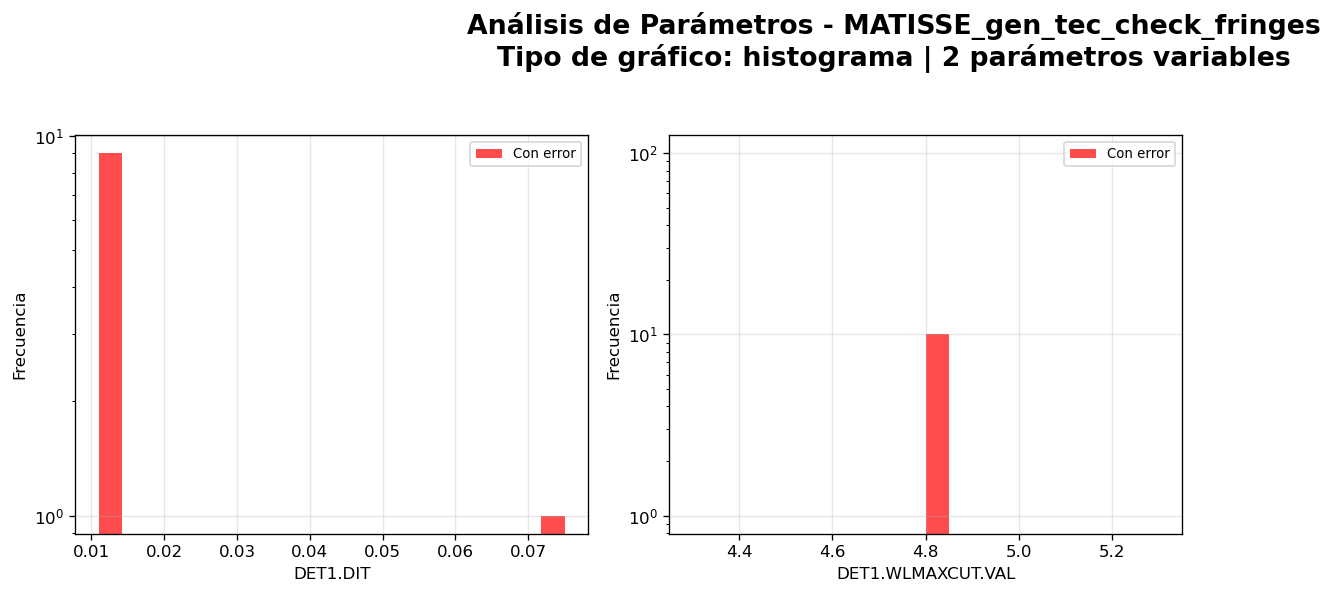

Creando gráficos tipo 'histograma' para 17 parámetros NO constantes...
Parámetros constantes (omitidos): ['COU.AG.EPOCH', 'COU.AG.EQUINOX', 'COU.AG.PMA', 'COU.AG.PMD', 'DEL.REF.OPL', 'DET1.APOTYPE.VAL', 'DET1.APOX.VAL', 'DET1.APOY.VAL', 'DET1.INTERFX.VAL', 'DET1.INTERFY.VAL', 'DET1.NCOHERENT.VAL', 'DET1.NINCOHERENT.VAL', 'DET1.SNRLIMIT.VAL', 'DET1.WLMINCUT.VAL', 'DET2.APOTYPE.VAL', 'DET2.APOX.VAL', 'DET2.APOY.VAL', 'DET2.INTERFX.VAL', 'DET2.INTERFY.VAL', 'DET2.NCOHERENT.VAL', 'DET2.NINCOHERENT.VAL', 'DET2.SNRLIMIT.VAL', 'DET2.WLMAXCUT.VAL', 'DET2.WLMINCUT.VAL', 'SEQ.ACQ.SKY.DURATION', 'SEQ.ACQ.TARG.DURATION', 'SEQ.DIL.WL0', 'SEQ.FS.INS.SFL.NAME', 'SEQ.FS.INS.SFN.NAME', 'SEQ.FS.SKY.DURATION', 'SEQ.FS.TARG.DURATION', 'SEQ.OPDM.L.WLMAX', 'SEQ.OPDM.N.WLMAX', 'SEQ.PUP.SKY.DURATION', 'SEQ.PUP.TARG.DURATION', 'SEQ.SKY.OFFS.ALPHA', 'SEQ.SKY.OFFS.DELTA', 'TEL.CHOP.POSANG', 'TEL.CHOP.PVRATIO', 'TEL.GS1.ALPHA', 'TEL.GS1.DELTA', 'TEL.GS1.MAG', 'TEL.TARG.ADDVELALPHA', 'TEL.TARG.ADDVELDELTA', 'TEL.T

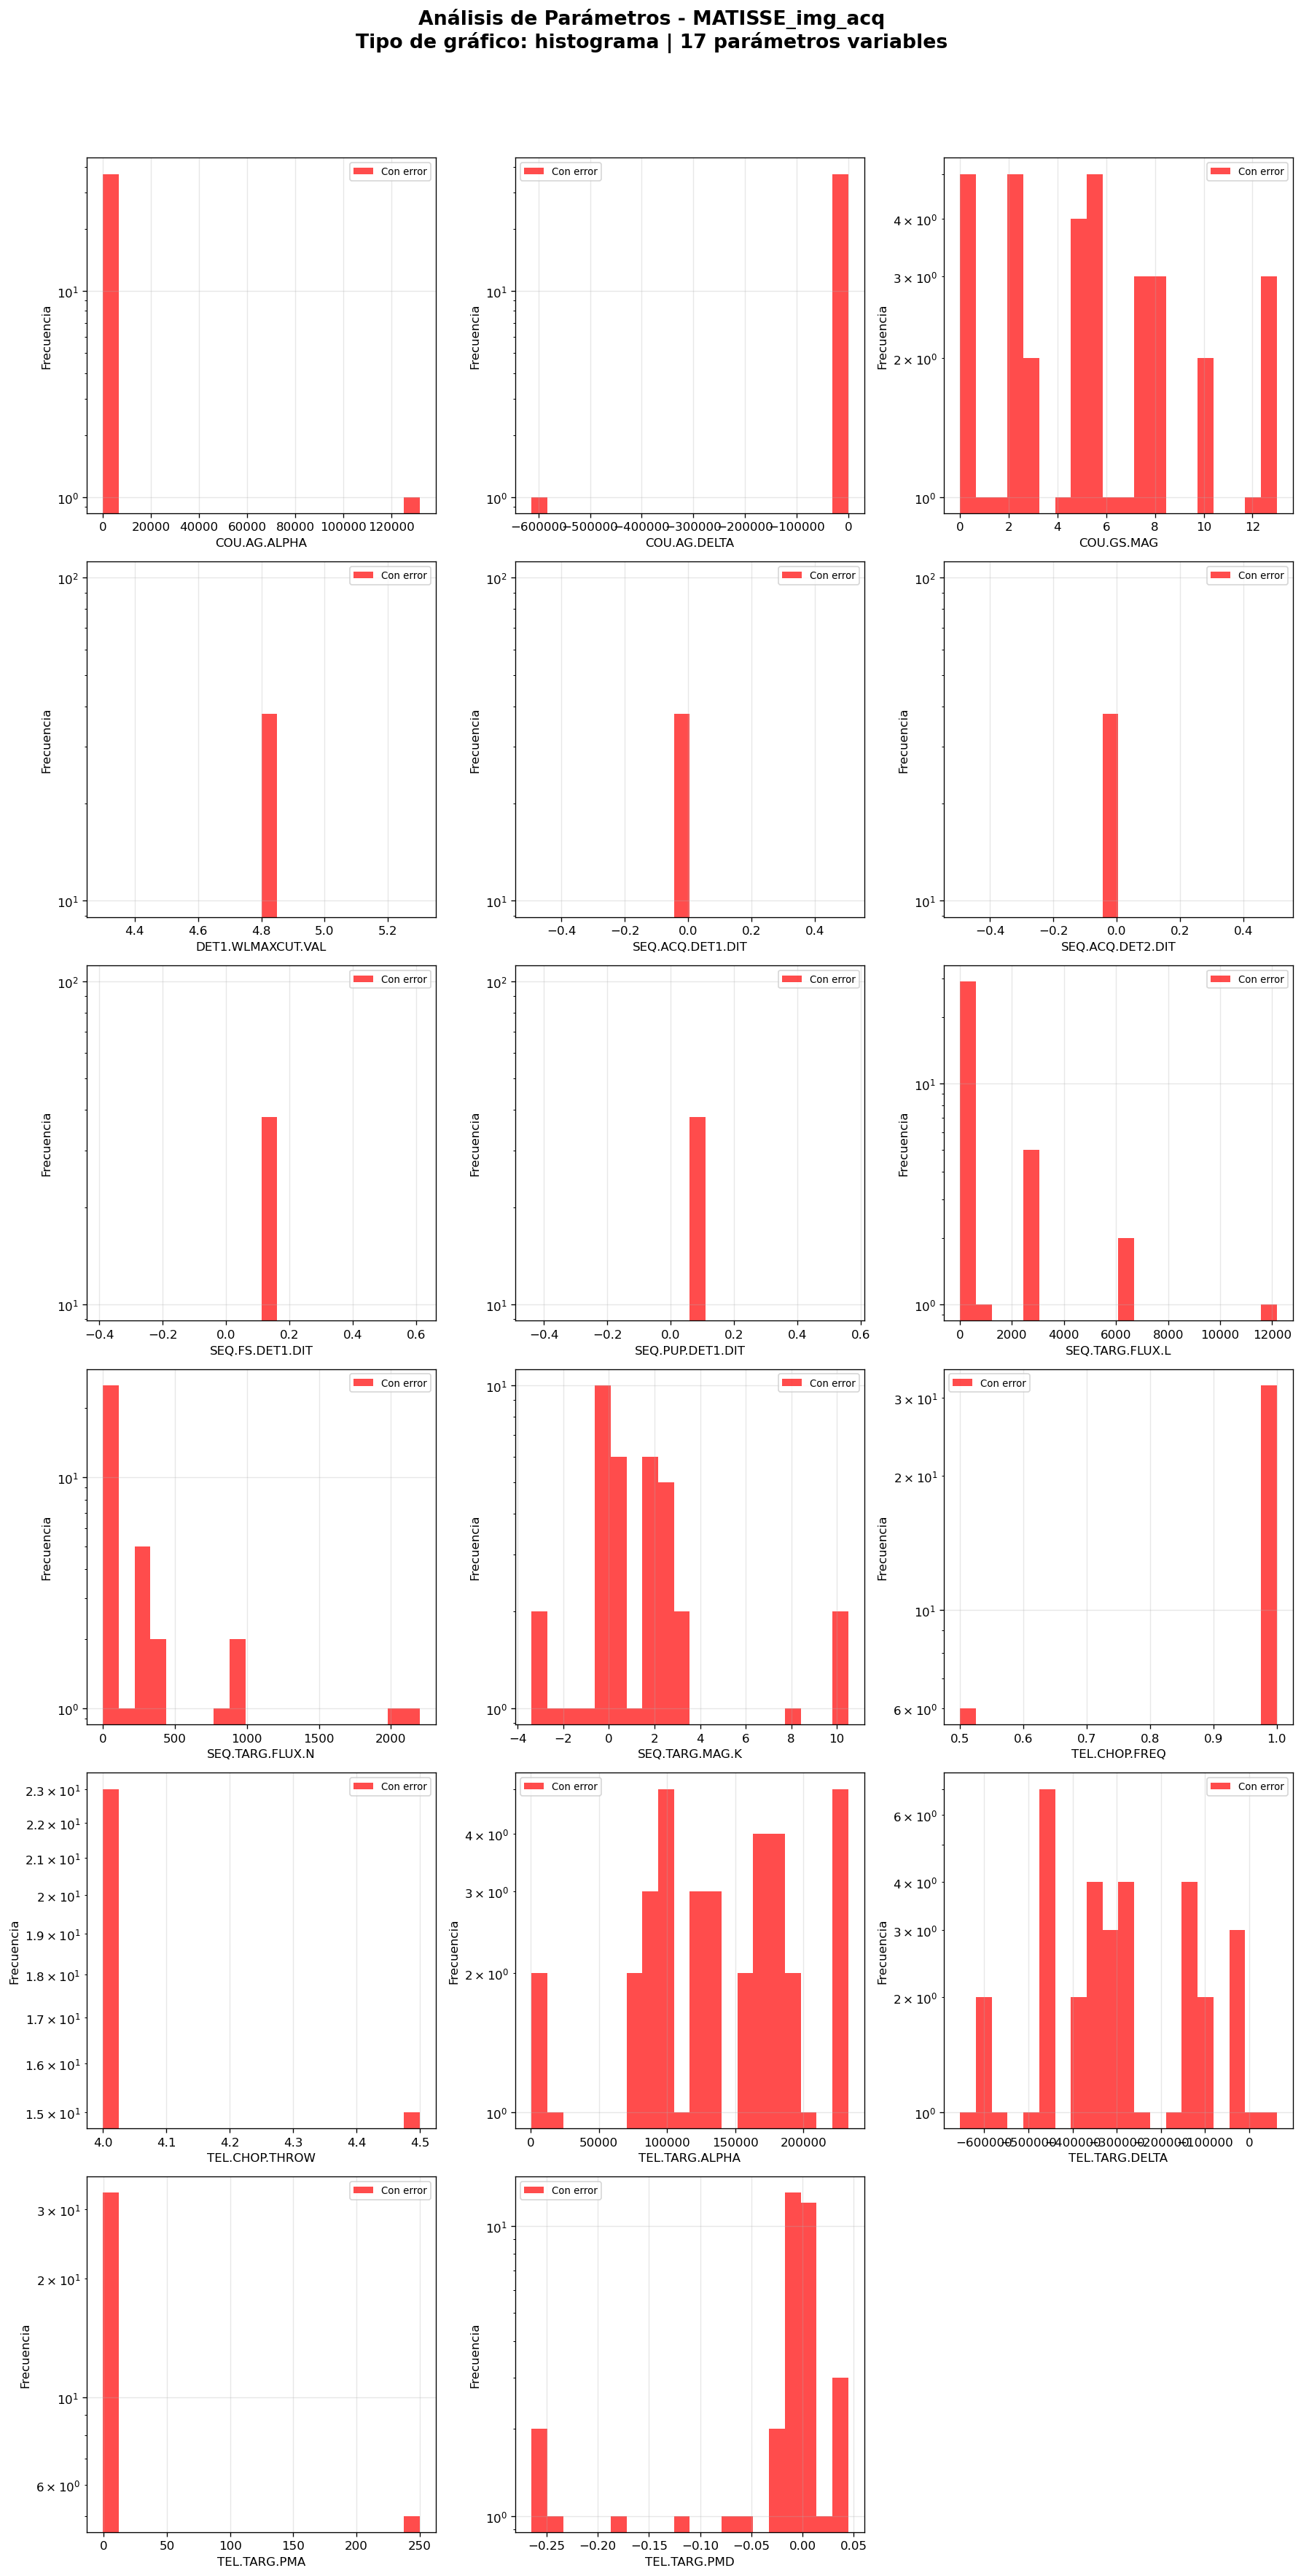

Creando gráficos tipo 'histograma' para 2 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.NDIT', 'DET1.NDITSKIP', 'DET1.PERIOD', 'DET1.TDELAY', 'DET1.WIN.MTCS1', 'DET1.WIN.MTCW1', 'DET1.WIN.MTRH1', 'DET1.WIN.MTRS1', 'SEQ.DARK.INS.SFL.NAME', 'SEQ.DITMAX', 'SEQ.LAMP.COOLDOWN']


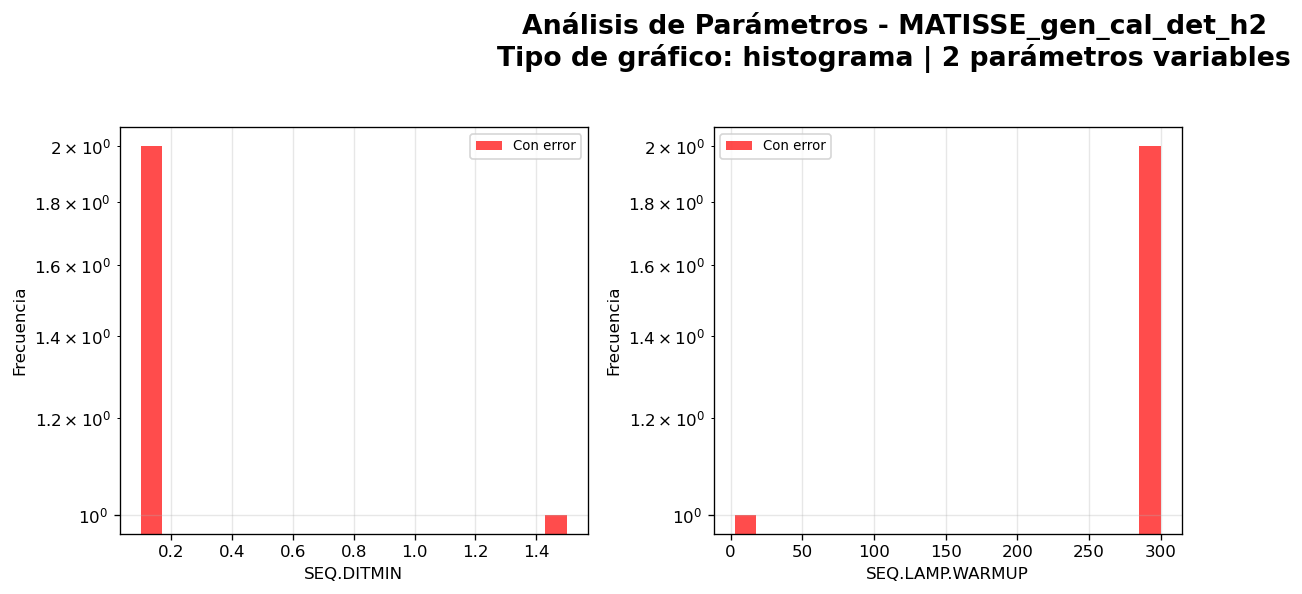

Creando gráficos tipo 'histograma' para 11 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.APOTYPE.VAL', 'DET1.APOX.VAL', 'DET1.APOY.VAL', 'DET1.INTERFX.VAL', 'DET1.INTERFY.VAL', 'DET1.NCOHERENT.VAL', 'DET1.NINCOHERENT.VAL', 'DET1.SNRLIMIT.VAL', 'DET1.WLMINCUT.VAL', 'DET2.APOTYPE.VAL', 'DET2.APOX.VAL', 'DET2.APOY.VAL', 'DET2.INTERFX.VAL', 'DET2.INTERFY.VAL', 'DET2.NCOHERENT.VAL', 'DET2.NINCOHERENT.VAL', 'DET2.SNRLIMIT.VAL', 'DET2.WLMAXCUT.VAL', 'DET2.WLMINCUT.VAL', 'INS.SFL.NAME', 'INS.SFN.NAME', 'SEQ.OPDM.L.WLMAX', 'SEQ.OPDM.N.WLMAX', 'TEL.CHOP.POSANG', 'TEL.CHOP.PVRATIO']


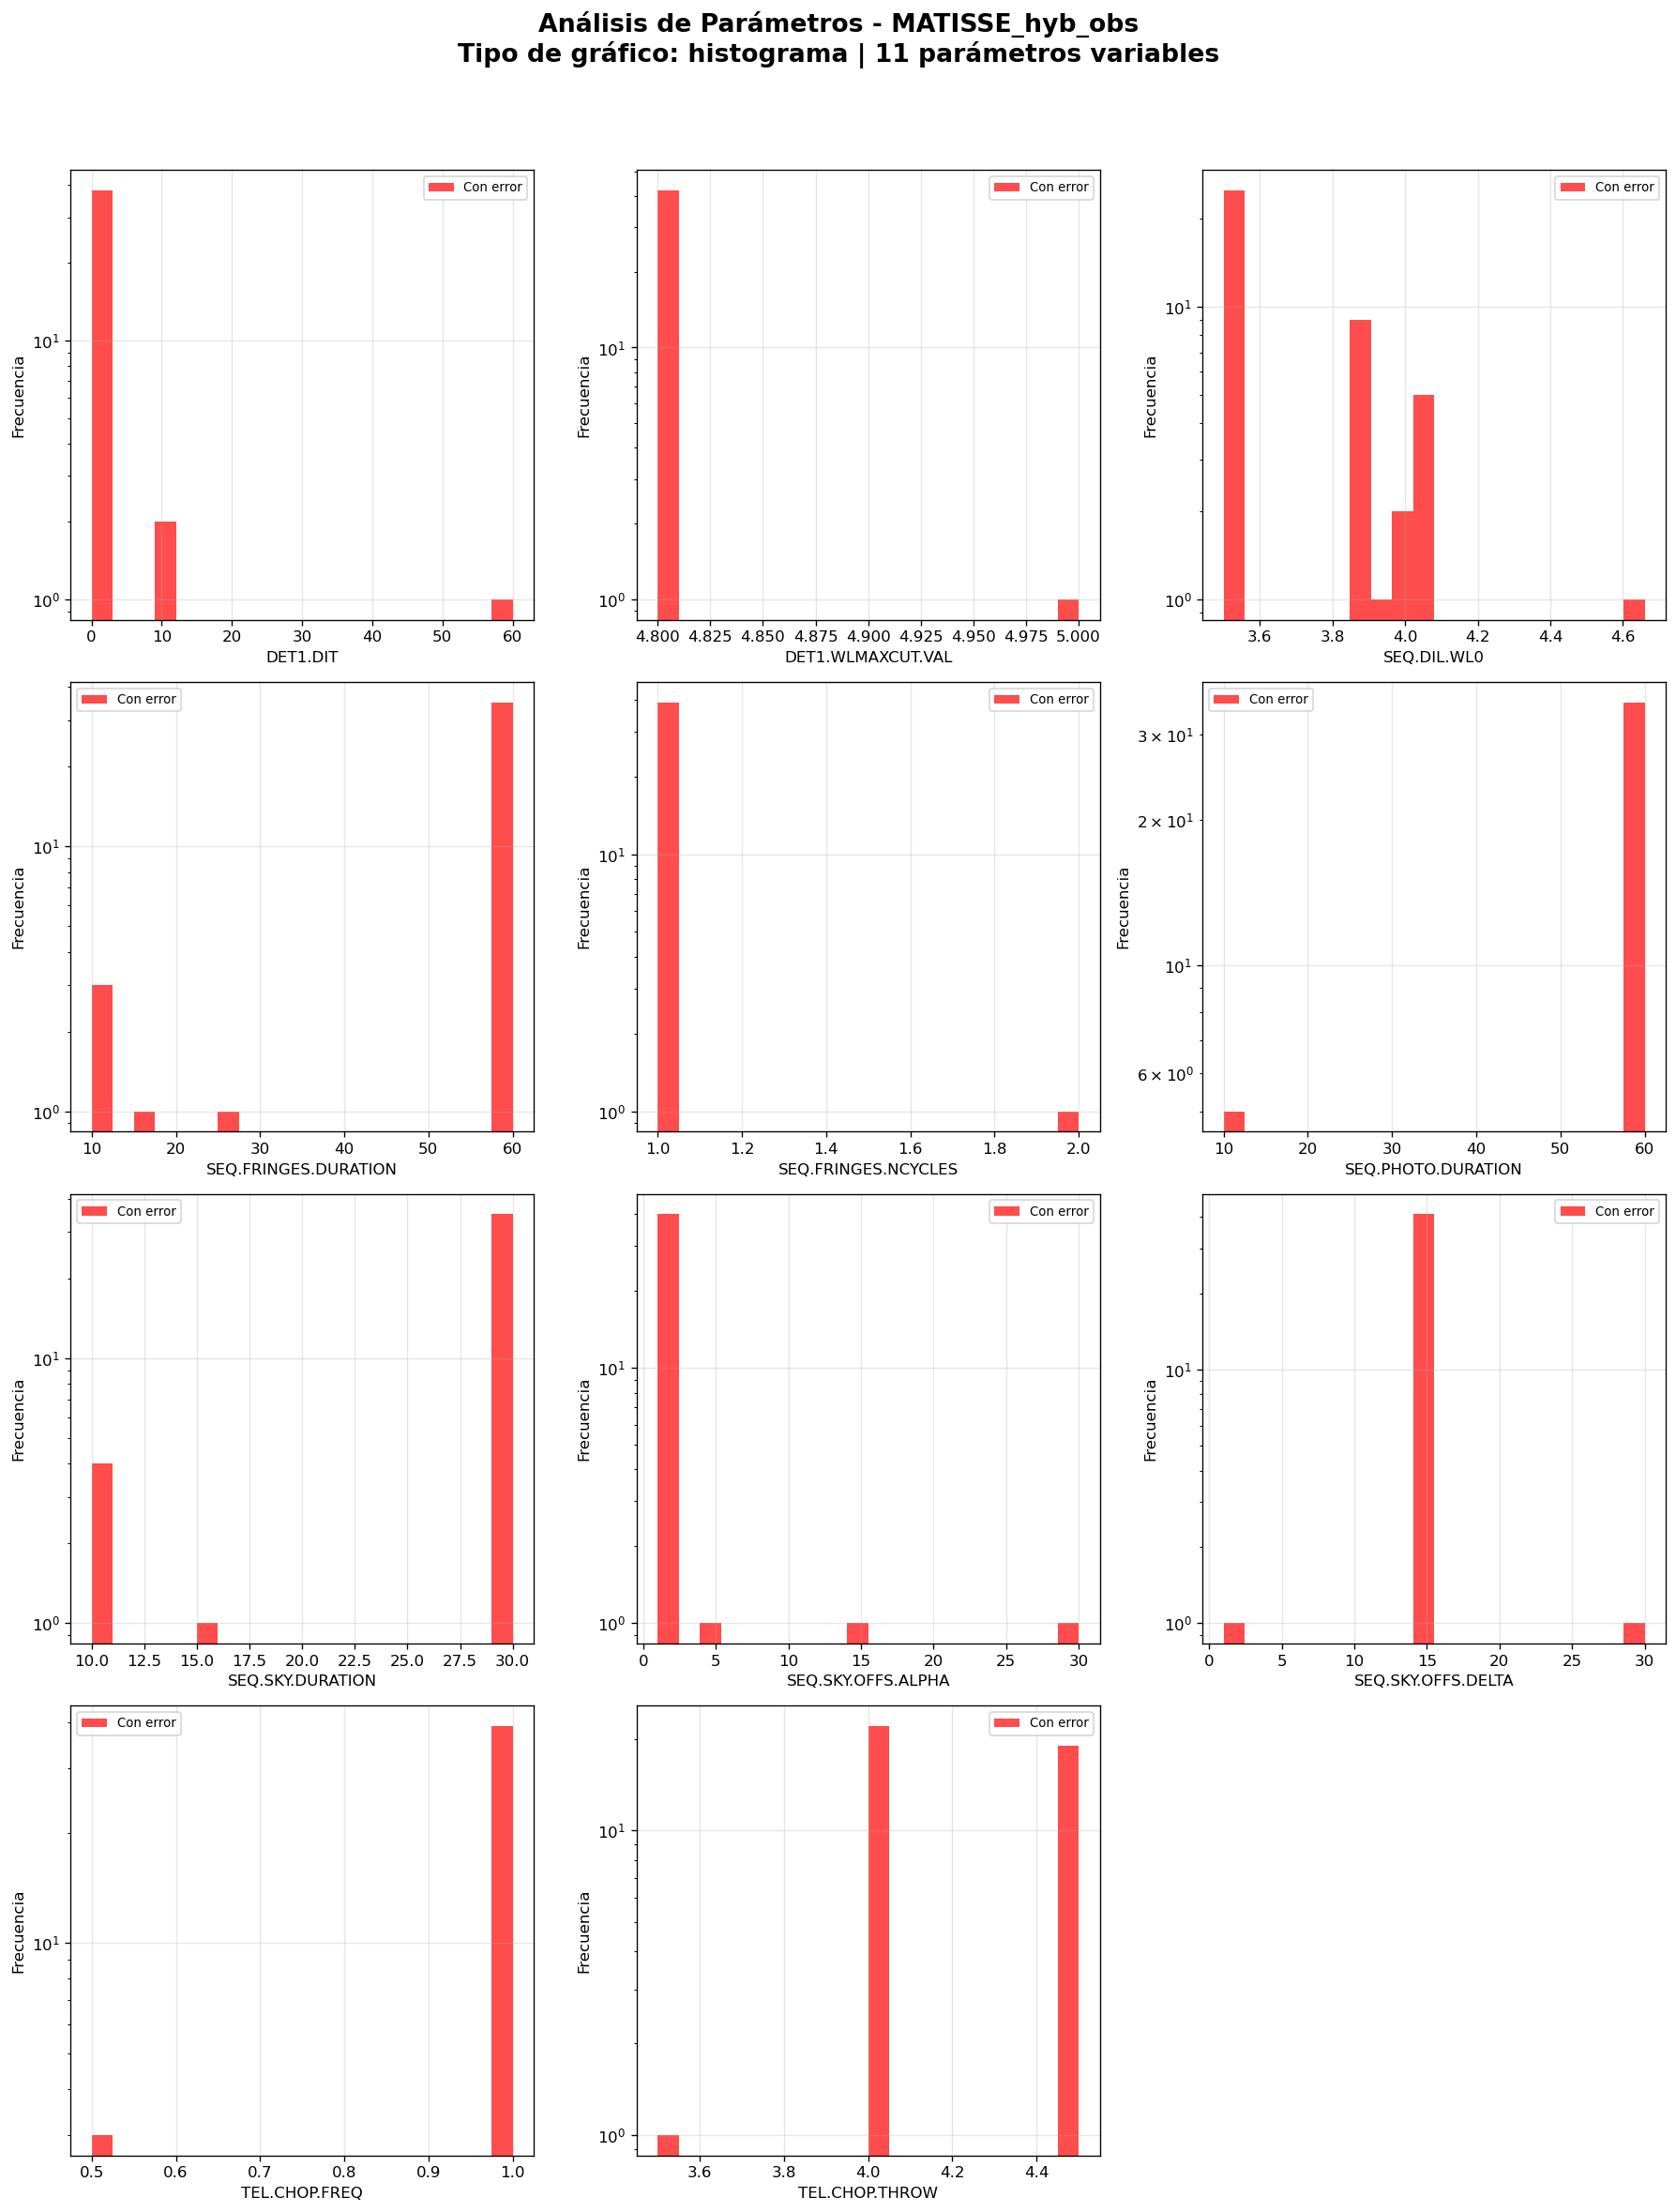

Creando gráficos tipo 'histograma' para 7 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.APOTYPE.VAL', 'DET1.APOX.VAL', 'DET1.APOY.VAL', 'DET1.INTERFX.VAL', 'DET1.INTERFY.VAL', 'DET1.NCOHERENT.VAL', 'DET1.NDIT', 'DET1.NINCOHERENT.VAL', 'DET1.WLMINCUT.VAL', 'DET2.APOTYPE.VAL', 'DET2.APOX.VAL', 'DET2.APOY.VAL', 'DET2.INTERFX.VAL', 'DET2.INTERFY.VAL', 'DET2.NDIT', 'DET2.NINCOHERENT.VAL', 'DET2.WLMINCUT.VAL', 'INS.SFL.NAME', 'INS.SFN.NAME']


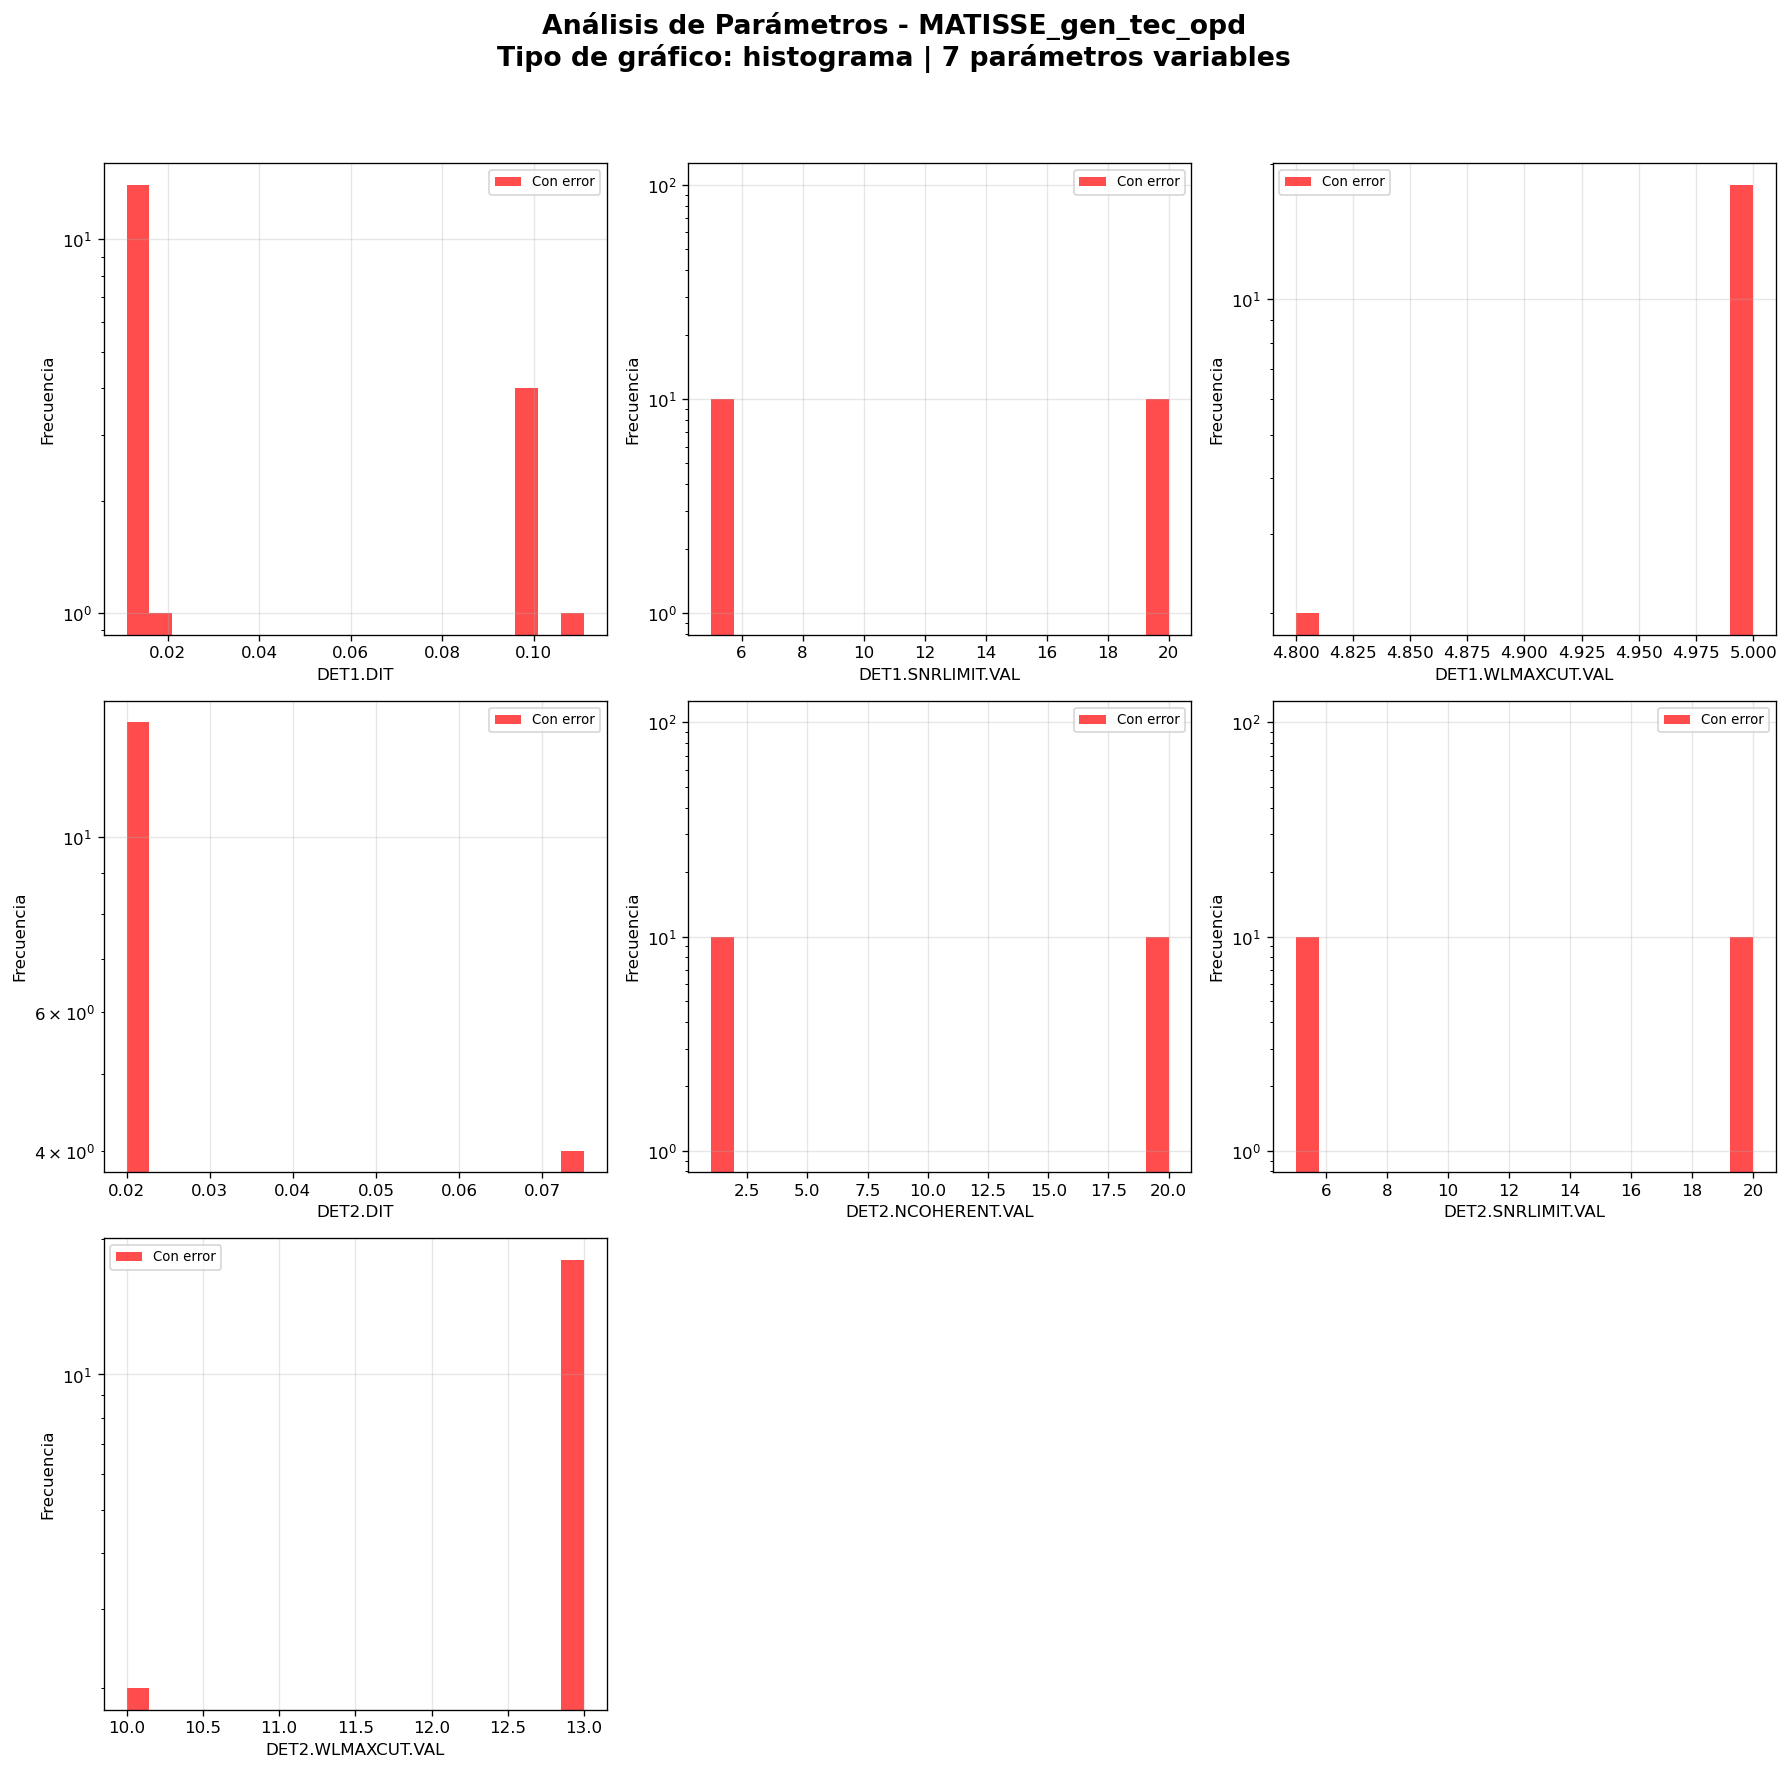

Creando gráficos tipo 'histograma' para 4 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.APOTYPE.VAL', 'DET1.APOX.VAL', 'DET1.APOY.VAL', 'DET1.INTERFX.VAL', 'DET1.INTERFY.VAL', 'DET1.NCOHERENT.VAL', 'DET1.NDIT', 'DET1.NINCOHERENT.VAL', 'DET1.SNRLIMIT.VAL', 'DET2.APOTYPE.VAL', 'DET2.APOX.VAL', 'DET2.APOY.VAL', 'DET2.DIT', 'DET2.INTERFX.VAL', 'DET2.INTERFY.VAL', 'DET2.NCOHERENT.VAL', 'DET2.NDIT', 'DET2.NINCOHERENT.VAL', 'DET2.SNRLIMIT.VAL', 'DET2.WLMAXCUT.VAL', 'DET2.WLMINCUT.VAL', 'INS.SFL.NAME', 'INS.SFN.NAME']


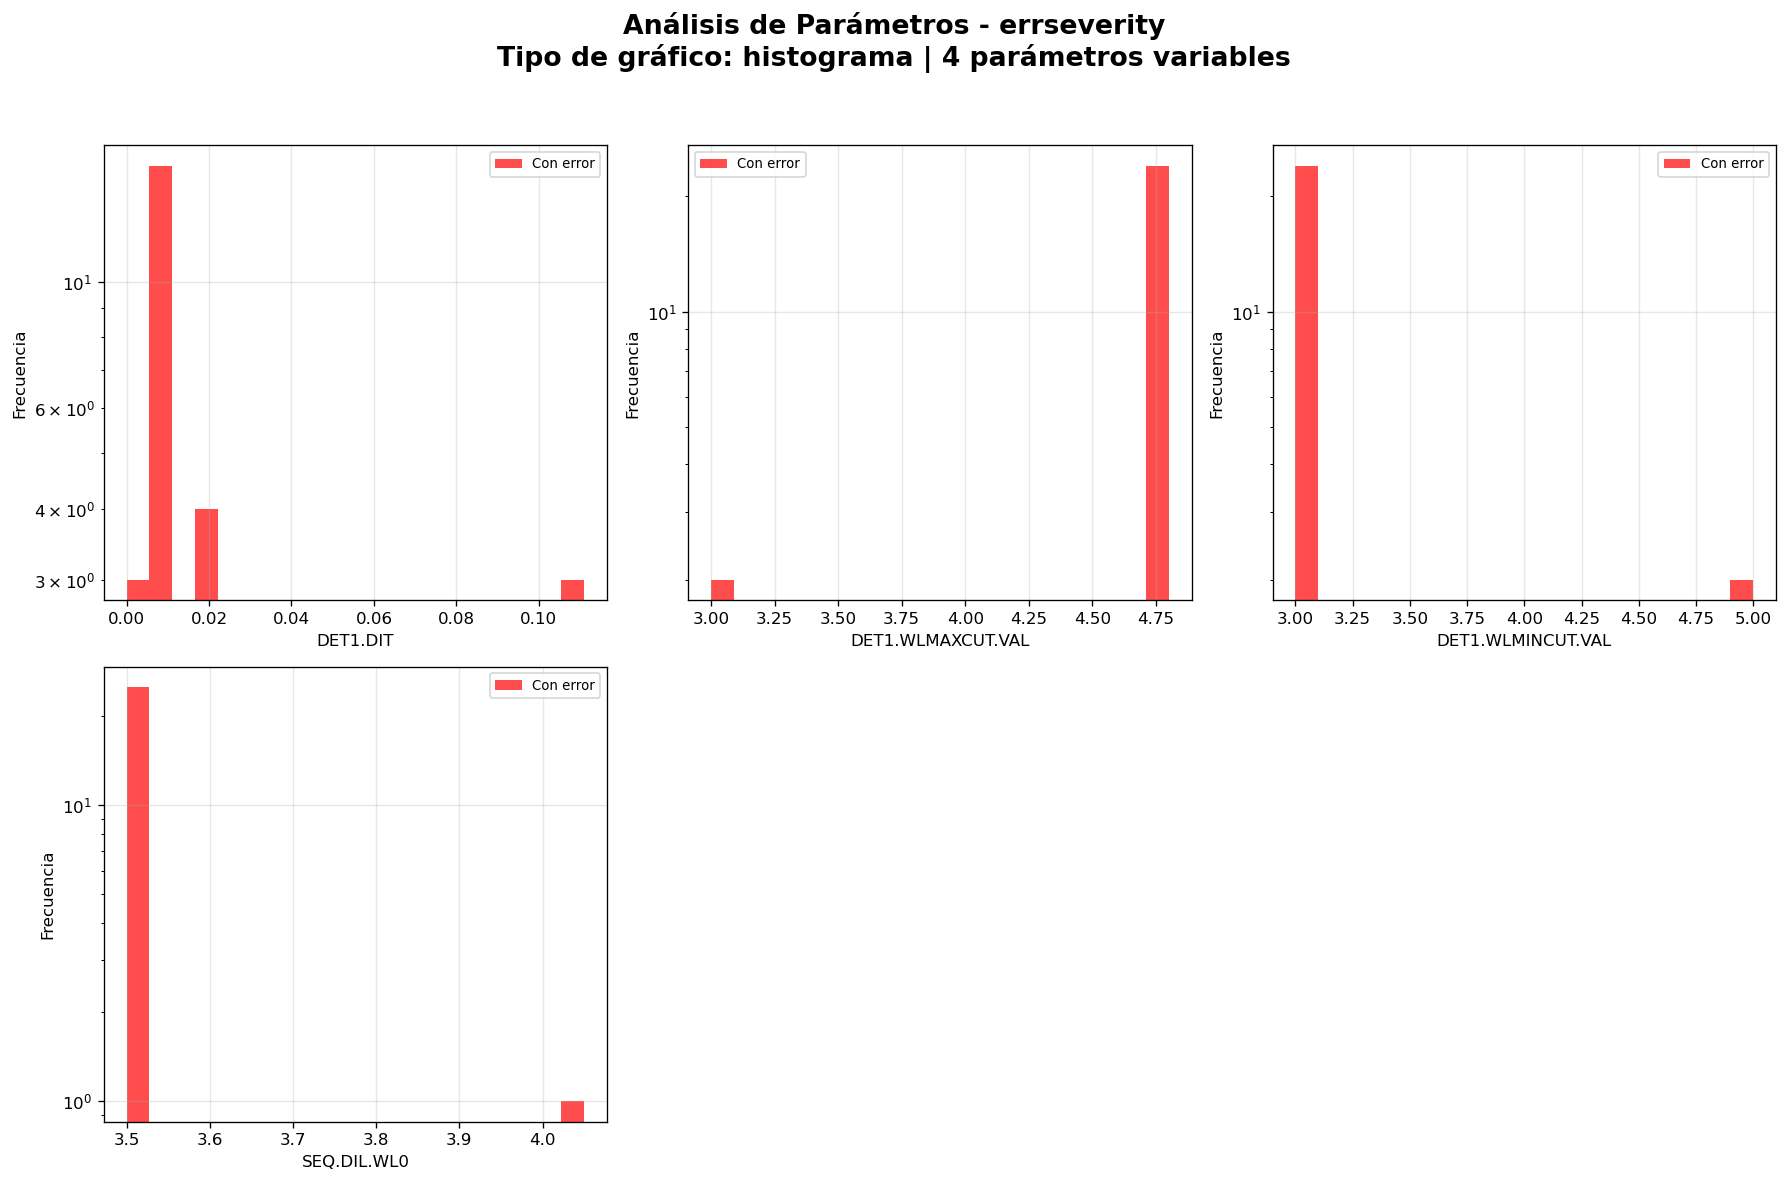

Creando gráficos tipo 'histograma' para 2 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET2.DIT', 'DET2.NDIT']


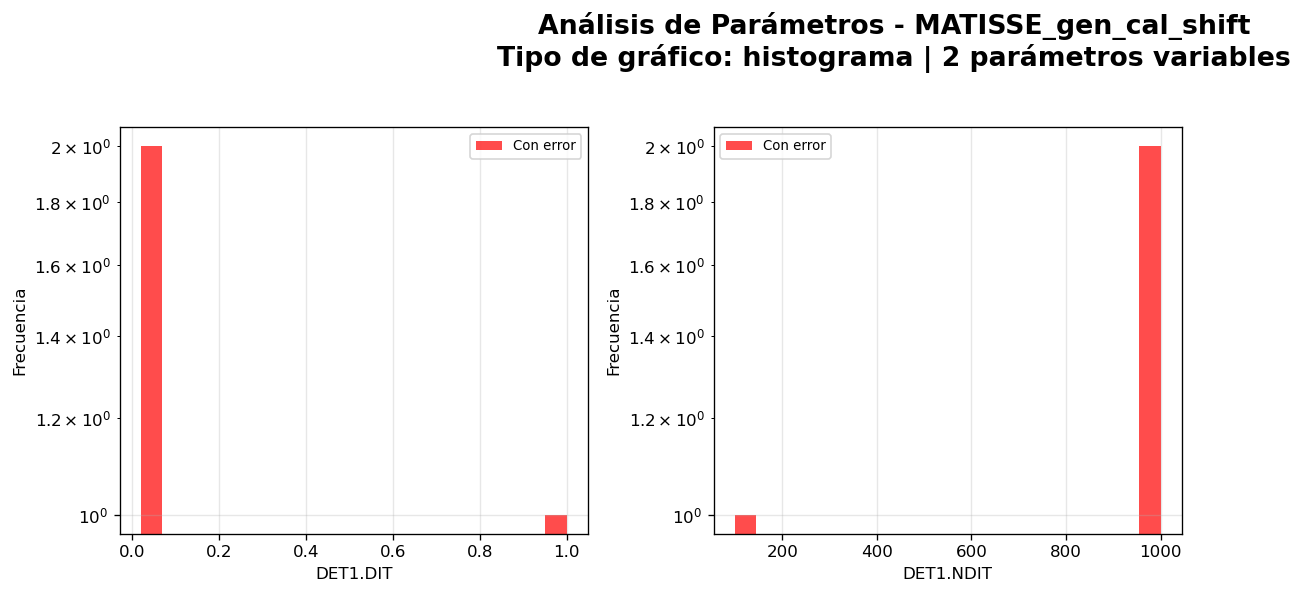

Creando gráficos tipo 'histograma' para 1 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.NDIT', 'DET2.DIT', 'DET2.NDIT']


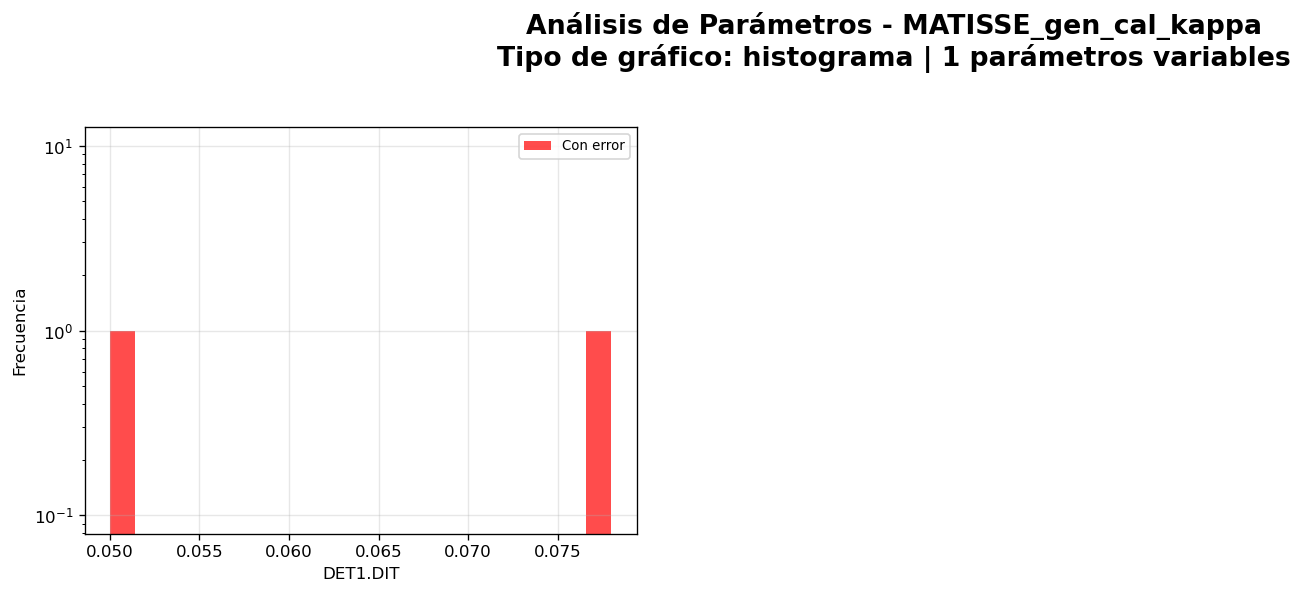

Creando gráficos tipo 'histograma' para 0 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.DIT', 'DET1.NDIT', 'DET2.DIT', 'DET2.NDIT', 'INS.SFL.NAME', 'INS.SFN.NAME', 'SEQ.PZT.END', 'SEQ.PZT.START', 'SEQ.PZT.STEP']
Todos los parámetros son constantes. No se generarán gráficos.
Creando gráficos tipo 'histograma' para 3 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.NDIT', 'DET1.NDITSKIP', 'DET1.TDELAY', 'DET1.WIN.MTCS.LIST', 'DET1.WIN.MTCW.LIST', 'DET1.WIN.NCOL', 'DET1.WIN.NROW', 'DET2.DIT', 'DET2.NDIT', 'DET2.NDITSKIP', 'DET2.TDELAY', 'DET2.WIN.MTCS.LIST', 'DET2.WIN.MTCW.LIST', 'DET2.WIN.NCOL', 'DET2.WIN.NROW', 'INS.SFL.NAME', 'INS.SFN.NAME', 'SEQ.LAMP.COOLDOWN']


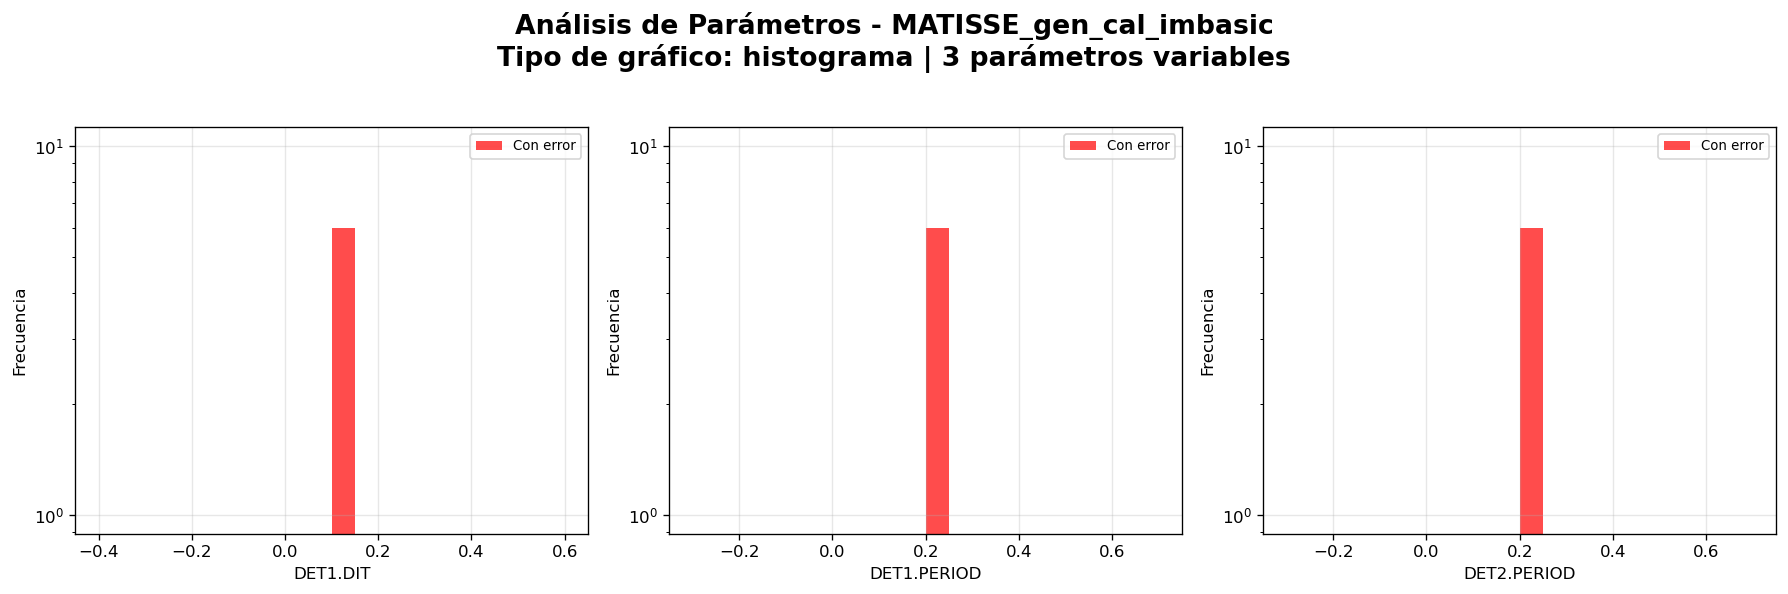

Creando gráficos tipo 'histograma' para 15 parámetros NO constantes...
Parámetros constantes (omitidos): ['COU.AG.ALPHA', 'COU.AG.DELTA', 'COU.AG.EPOCH', 'COU.AG.EQUINOX', 'COU.AG.PMA', 'COU.AG.PMD', 'DEL.REF.NAME', 'DEL.REF.OPL', 'DET1.APOTYPE.VAL', 'DET1.APOX.VAL', 'DET1.APOY.VAL', 'DET1.INTERFX.VAL', 'DET1.INTERFY.VAL', 'DET1.NCOHERENT.VAL', 'DET1.NINCOHERENT.VAL', 'DET1.SNRLIMIT.VAL', 'DET1.WLMINCUT.VAL', 'DET2.APOTYPE.VAL', 'DET2.APOX.VAL', 'DET2.APOY.VAL', 'DET2.DIT', 'DET2.INTERFX.VAL', 'DET2.INTERFY.VAL', 'DET2.NCOHERENT.VAL', 'DET2.NDIT.SKY', 'DET2.NINCOHERENT.VAL', 'DET2.SNRLIMIT.VAL', 'DET2.WLMINCUT.VAL', 'INS.STSOFFANG', 'SEQ.ACQ.SKY.DURATION', 'SEQ.ACQ.TARG.DURATION', 'SEQ.DIL.WL0', 'SEQ.OPDM.L.WLMAX', 'SEQ.OPDM.N.WLMAX', 'SEQ.PUP.SKY.DURATION', 'SEQ.PUP.TARG.DURATION', 'SEQ.SKY.OFFS.ALPHA', 'SEQ.SKY.OFFS.DELTA', 'SEQ.SKY.X', 'SEQ.SKY.Y', 'TEL.GS1.ALPHA', 'TEL.GS1.DELTA', 'TEL.GS1.MAG', 'TEL.TARG.ADDVELALPHA', 'TEL.TARG.ADDVELDELTA', 'TEL.TARG.EQUINOX']


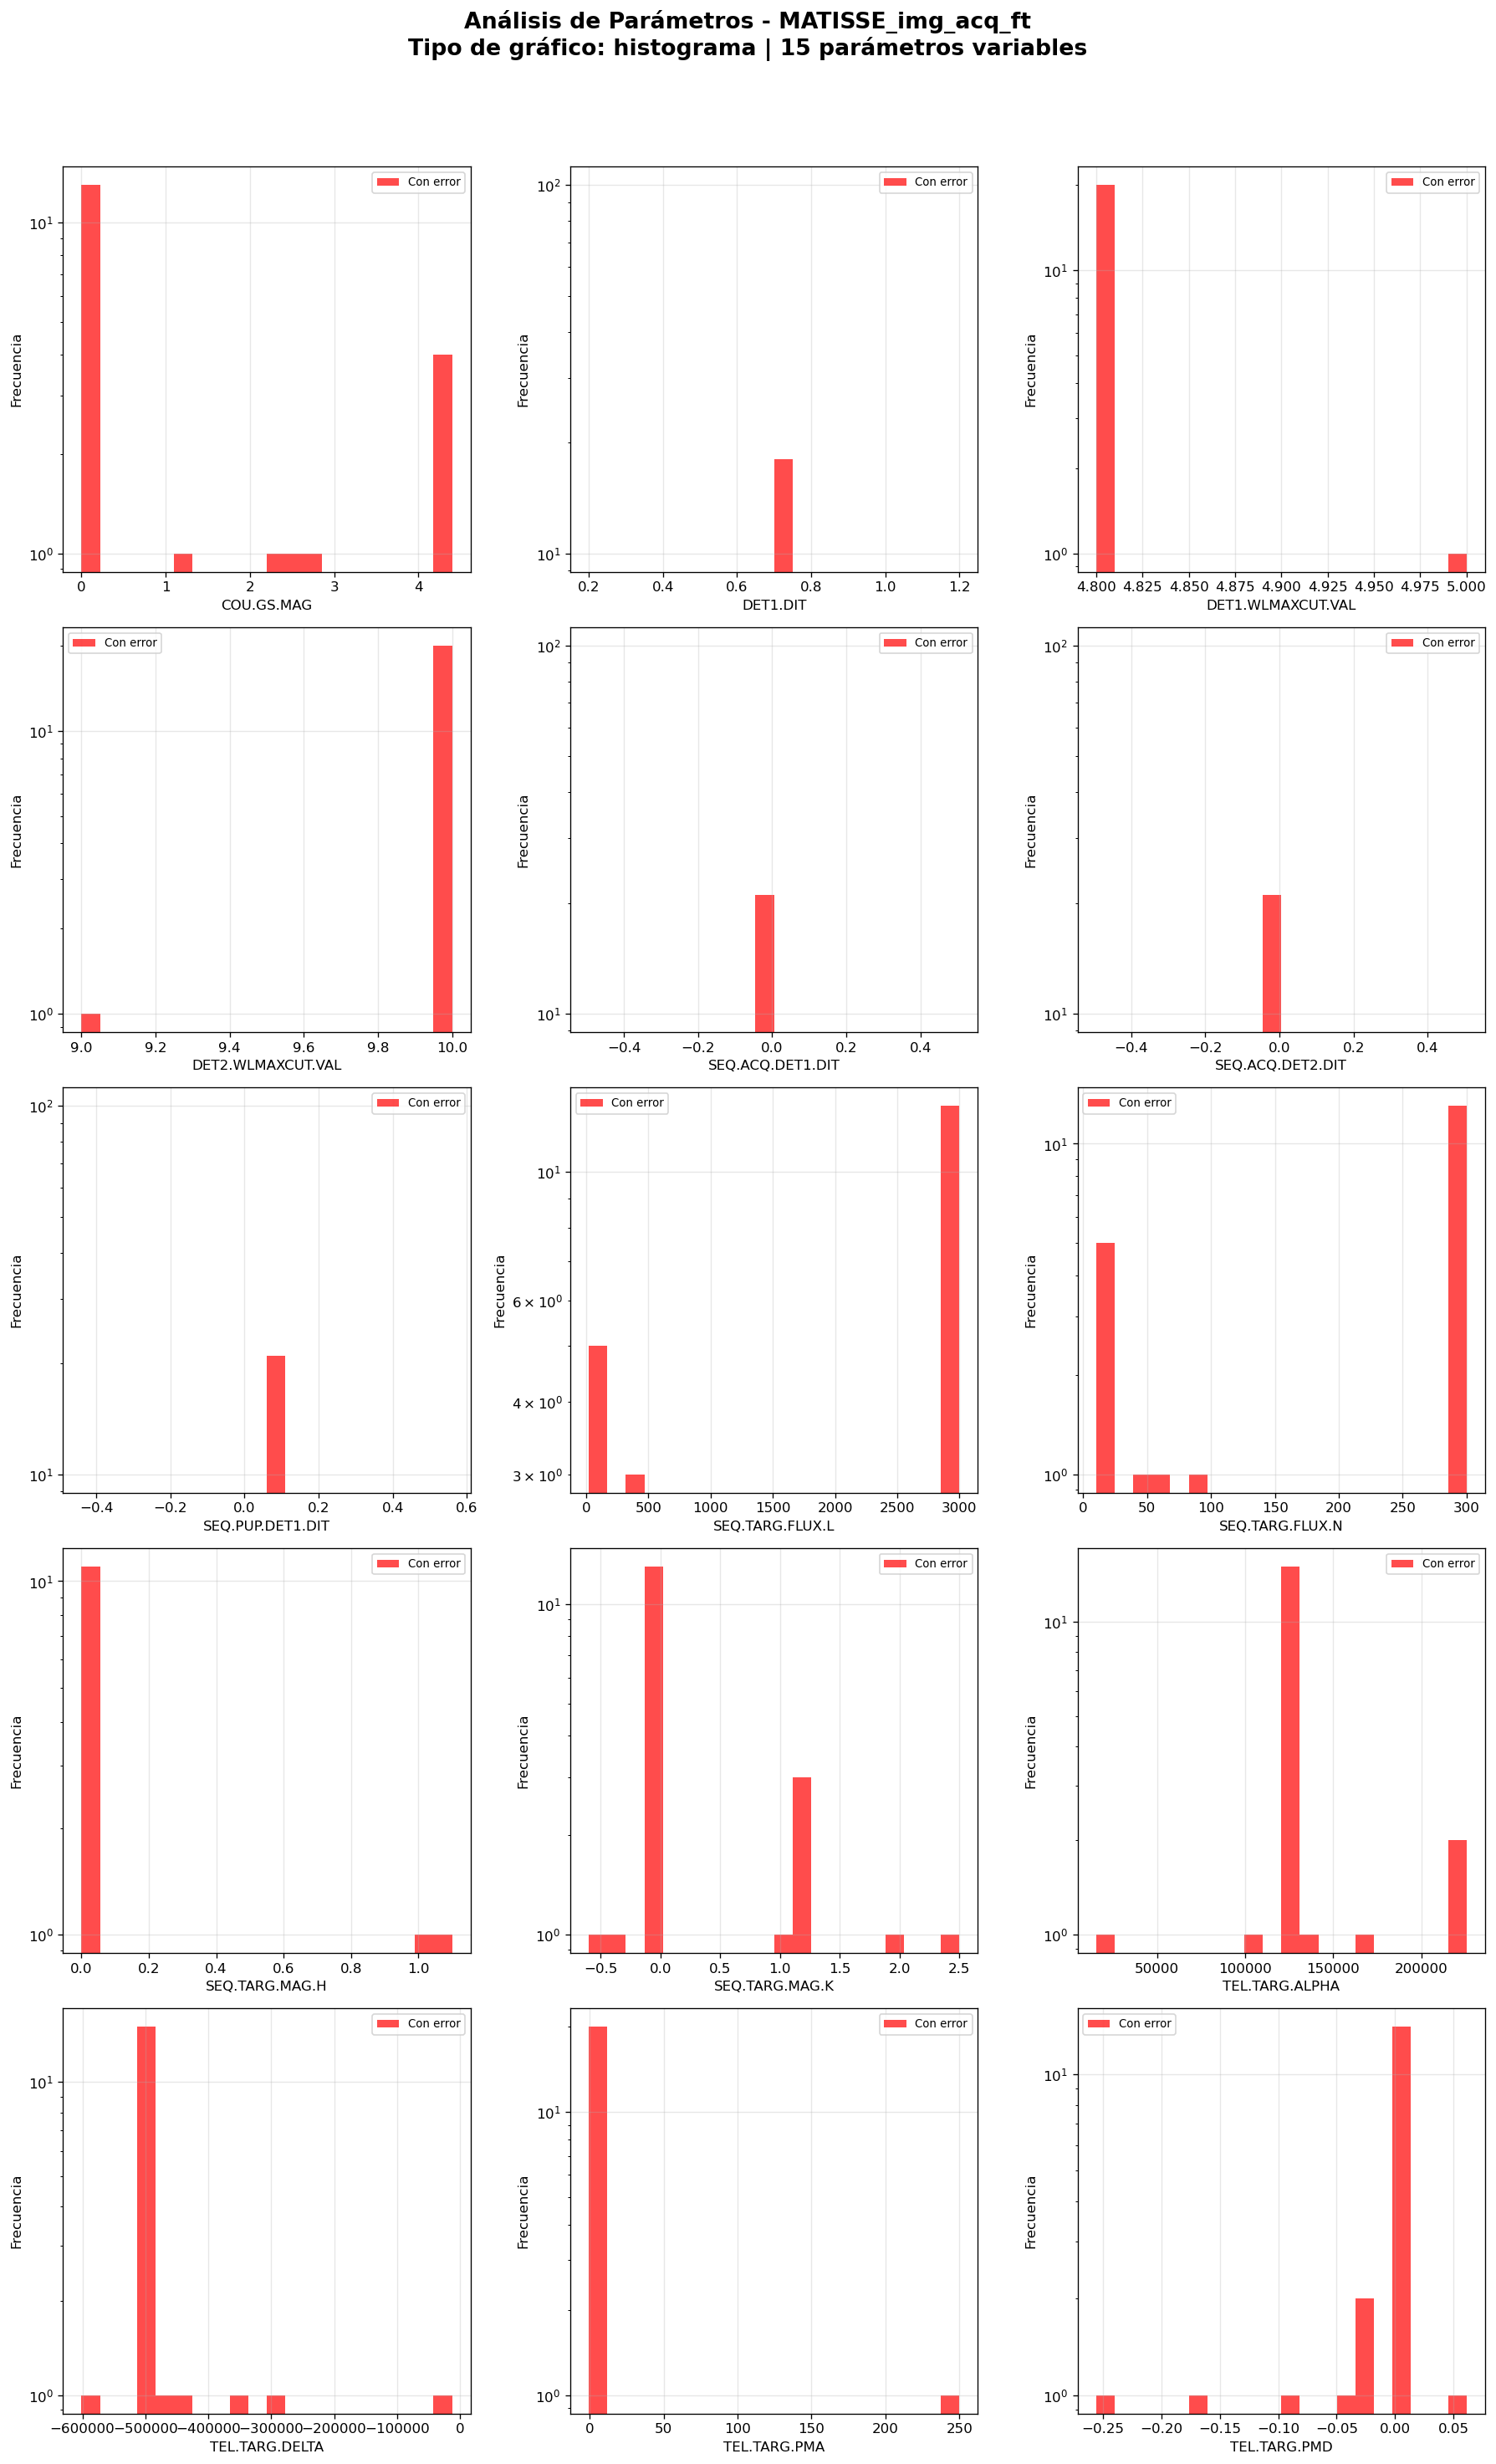

Creando gráficos tipo 'histograma' para 3 parámetros NO constantes...


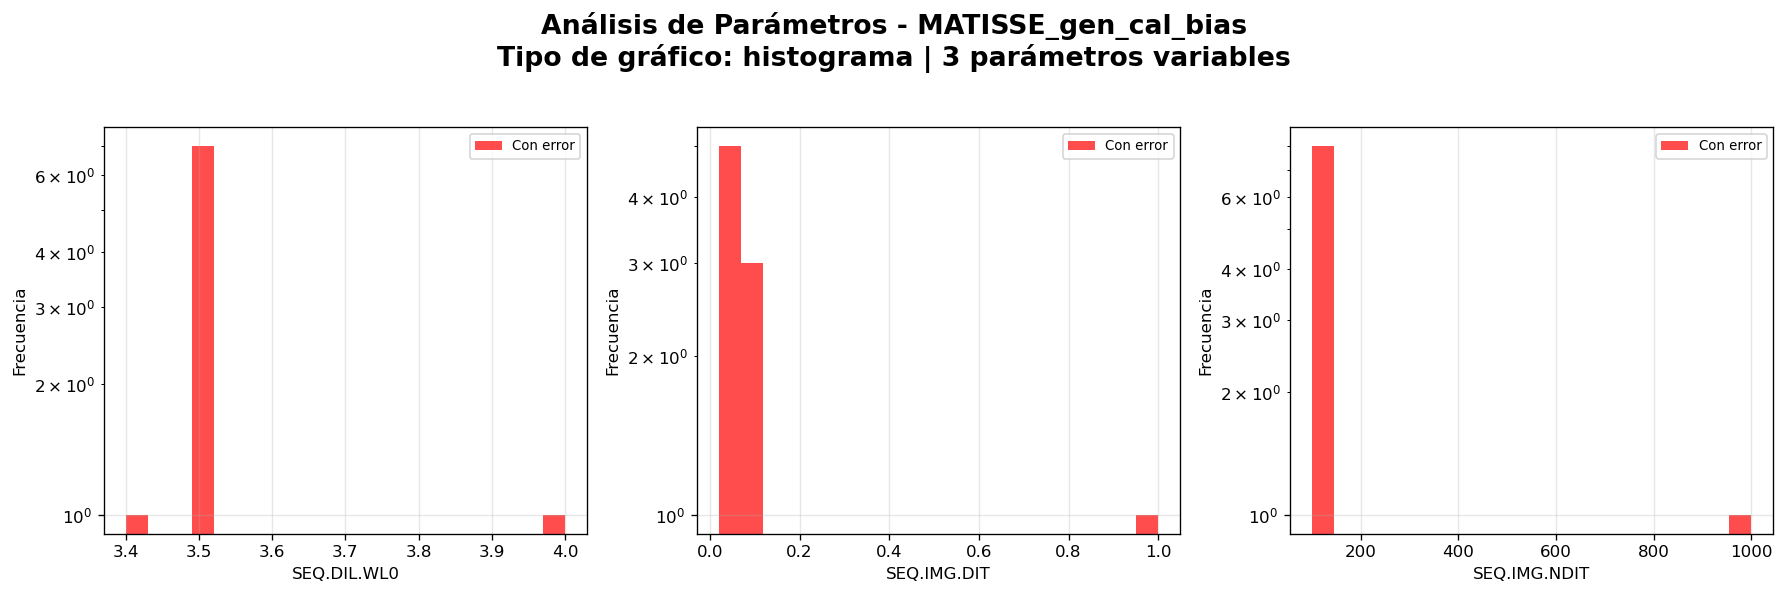

Creando gráficos tipo 'histograma' para 1 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET2.NDIT', 'DET2.NDITSKIP', 'DET2.PERIOD', 'DET2.TDELAY', 'DET2.WIN.MTCS1', 'DET2.WIN.MTCW1', 'DET2.WIN.MTRH1', 'DET2.WIN.MTRS1', 'SEQ.DARK.INS.SFN.NAME', 'SEQ.LAMP.COOLDOWN', 'SEQ.LAMP.WARMUP']


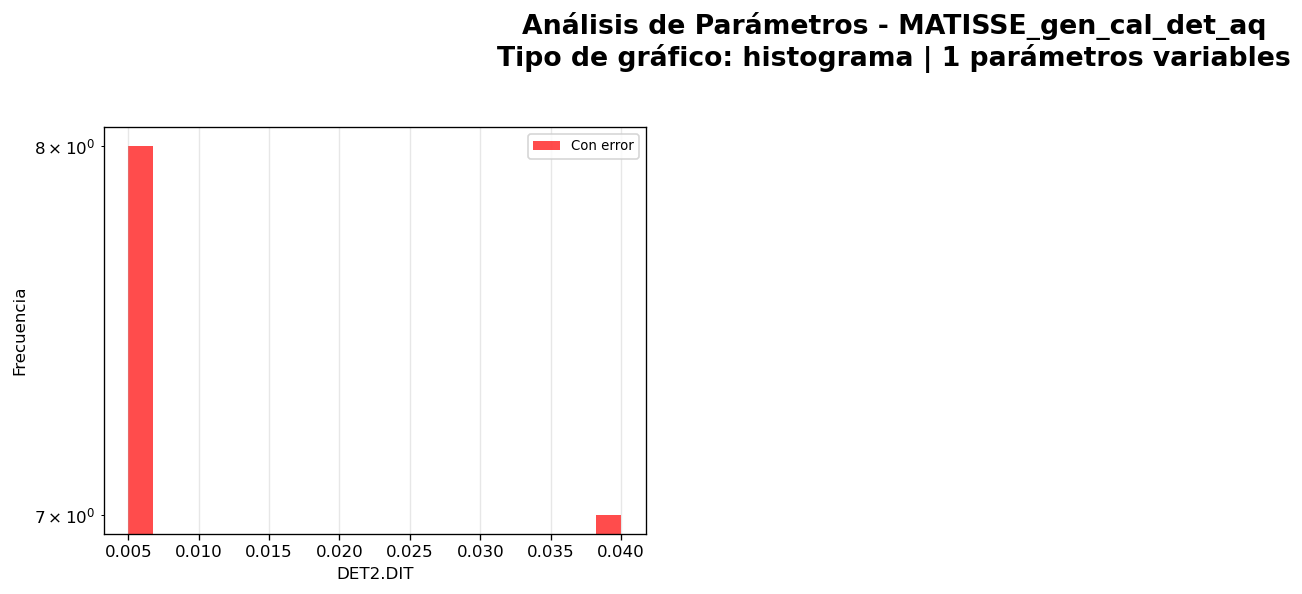

Creando gráficos tipo 'histograma' para 8 parámetros NO constantes...


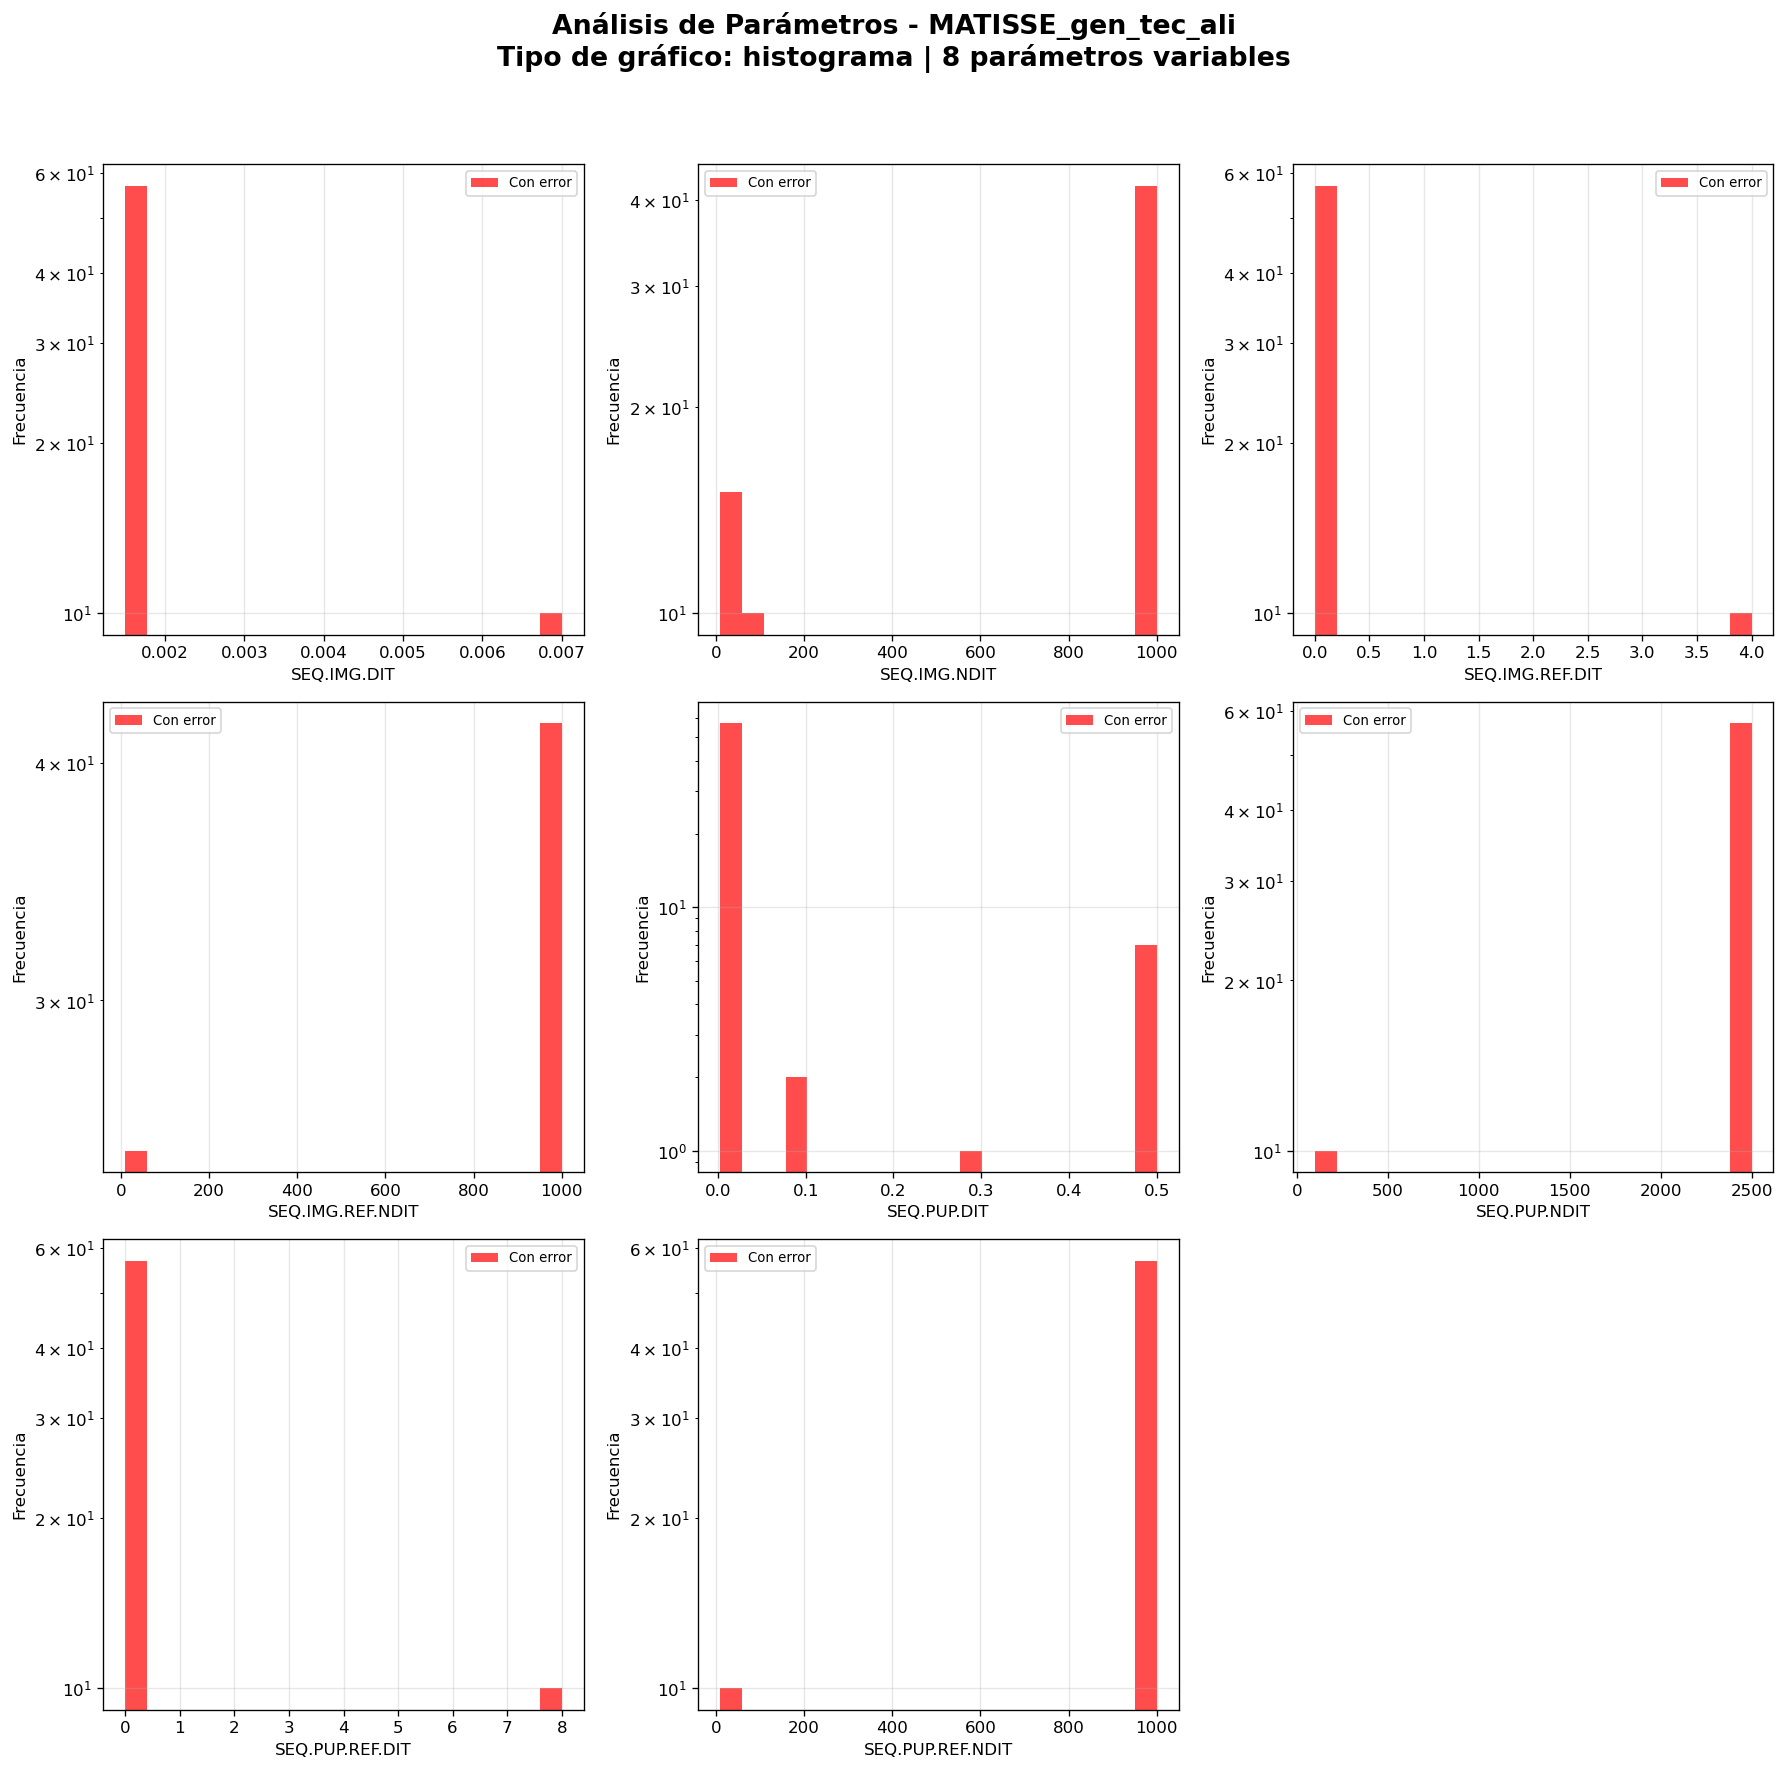

Creando gráficos tipo 'histograma' para 0 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.APOTYPE.VAL', 'DET1.APOX.VAL', 'DET1.APOY.VAL', 'DET1.DIT', 'DET1.INTERFX.VAL', 'DET1.INTERFY.VAL', 'DET1.NCOHERENT.VAL', 'DET1.NINCOHERENT.VAL', 'DET1.SNRLIMIT.VAL', 'DET1.WLMAXCUT.VAL', 'DET1.WLMINCUT.VAL', 'DET2.APOTYPE.VAL', 'DET2.APOX.VAL', 'DET2.APOY.VAL', 'DET2.DIT', 'DET2.INTERFX.VAL', 'DET2.INTERFY.VAL', 'DET2.NCOHERENT.VAL', 'DET2.NINCOHERENT.VAL', 'DET2.SNRLIMIT.VAL', 'DET2.WLMAXCUT.VAL', 'DET2.WLMINCUT.VAL', 'INS.SFL.NAME', 'INS.SFN.NAME', 'SEQ.DARK.DURATION', 'SEQ.DIL.WL0', 'SEQ.FRINGES.DURATION', 'SEQ.FRINGES.NCYCLES', 'SEQ.OPDM.L.WLMAX', 'SEQ.OPDM.N.WLMAX', 'SEQ.OPDM.NSTEPS', 'SEQ.PHOTO.DURATION', 'SEQ.SKY.DURATION', 'TEL.CHOP.FREQ', 'TEL.CHOP.POSANG', 'TEL.CHOP.PVRATIO', 'TEL.CHOP.THROW']
Todos los parámetros son constantes. No se generarán gráficos.


In [9]:

for tpl_id_str, df_err in tpl_params_dict_err.items():
    if df_err.empty:
        print(f"{tpl_id_str}: DataFrame vacío (ERR: {len(df_err)})")
        continue

    # Seleccionamos solo columnas numéricas válidas
    df_err_num = df_err.apply(pd.to_numeric, errors="coerce")
    cols_num = sorted(df_err_num.select_dtypes(include="number").columns)

    if not cols_num:
        print(f"{tpl_id_str}: Sin columnas numéricas válidas para histograma")
        continue

    graficos_por_columna(None, df_err_num[cols_num], nombre_archivo=tpl_id_str, tipo="histograma", log_y=True)



## 2. Extracción y Codificación de Parámetros Categóricos

Se extraen los parametros con valor categoricos, para posteriormente codificarlos numéricamente y visualizar los resultados.

### Extracción de Parámetros Categóricos (strval) en Memoria
Se extraen los parámetros categóricos de las trazas y se almacenan directamente en diccionarios de DataFrames en memoria. 

In [10]:
tpl_strval_dict_err = {}

for tpl_id in df_meta['TPL_ID'].unique():
    strval_df_err = extract_trace_categoricals(
        df_meta,      # ya está filtrado con ERROR==True
        df_traces, 
        extract_params,
        tpl_id=tpl_id
    )

    if strval_df_err is not None and not strval_df_err.empty:
        tpl_strval_dict_err[tpl_id] = strval_df_err

print(f"Se extrajeron parámetros categóricos para {len(tpl_strval_dict_err)} TPL_ID con errores.")


Se extrajeron parámetros categóricos para 15 TPL_ID con errores.


### Codificación de Parámetros Categóricos en Memoria
Se aplica una codificación numérica a los parámetros categóricos directamente desde los DataFrames en memoria.

In [11]:
codified_strval_err_dfs, dict_codificacion_err = procesar_strval_in_memory(
    tpl_strval_dict_err
)

print("\nCodificación de categóricas completada (solo errores).")
print(f"TPL_ID procesados: {len(codified_strval_err_dfs)}")



Codificación de categóricas completada (solo errores).
TPL_ID procesados: 15


### Gráficos de Parámetros Categóricos Codificados
Se generan gráficos de pie para los parámetros categóricos ya codificados, comparando las observaciones con y sin error. Se aplica el mismo filtro de parámetros constantes que en la sección de numéricos, utilizando los DataFrames en memoria.

Creando gráficos tipo 'pie' para 4 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.APOTYPE.VAL', 'DET1.APOX.VAL', 'DET1.APOY.VAL', 'DET1.DIT', 'DET1.INTERFX.VAL', 'DET1.INTERFY.VAL', 'DET1.NCOHERENT.VAL', 'DET1.NDIT', 'DET1.NINCOHERENT.VAL', 'DET1.SNRLIMIT.VAL', 'DET1.WLMAXCUT.VAL', 'DET1.WLMINCUT.VAL', 'DET2.APOTYPE.VAL', 'DET2.APOX.VAL', 'DET2.APOY.VAL', 'DET2.INTERFX.VAL', 'DET2.INTERFY.VAL', 'DET2.NCOHERENT.VAL', 'DET2.NDIT', 'DET2.NINCOHERENT.VAL', 'DET2.READ.CURNAME', 'DET2.SNRLIMIT.VAL', 'DET2.WLMAXCUT.VAL', 'DET2.WLMINCUT.VAL', 'DPR.TECH', 'INS.DIL.NAME', 'INS.DIN.NAME', 'INS.FIN.NAME', 'INS.PIL.NAME', 'INS.PIN.NAME', 'INS.POL.NAME', 'INS.PON.NAME', 'INS.SFL.NAME', 'INS.SFN.NAME', 'SEQ.DIL.WL0', 'SEQ.SIMUL.DIR', 'SEQ.SIMUL.ST']


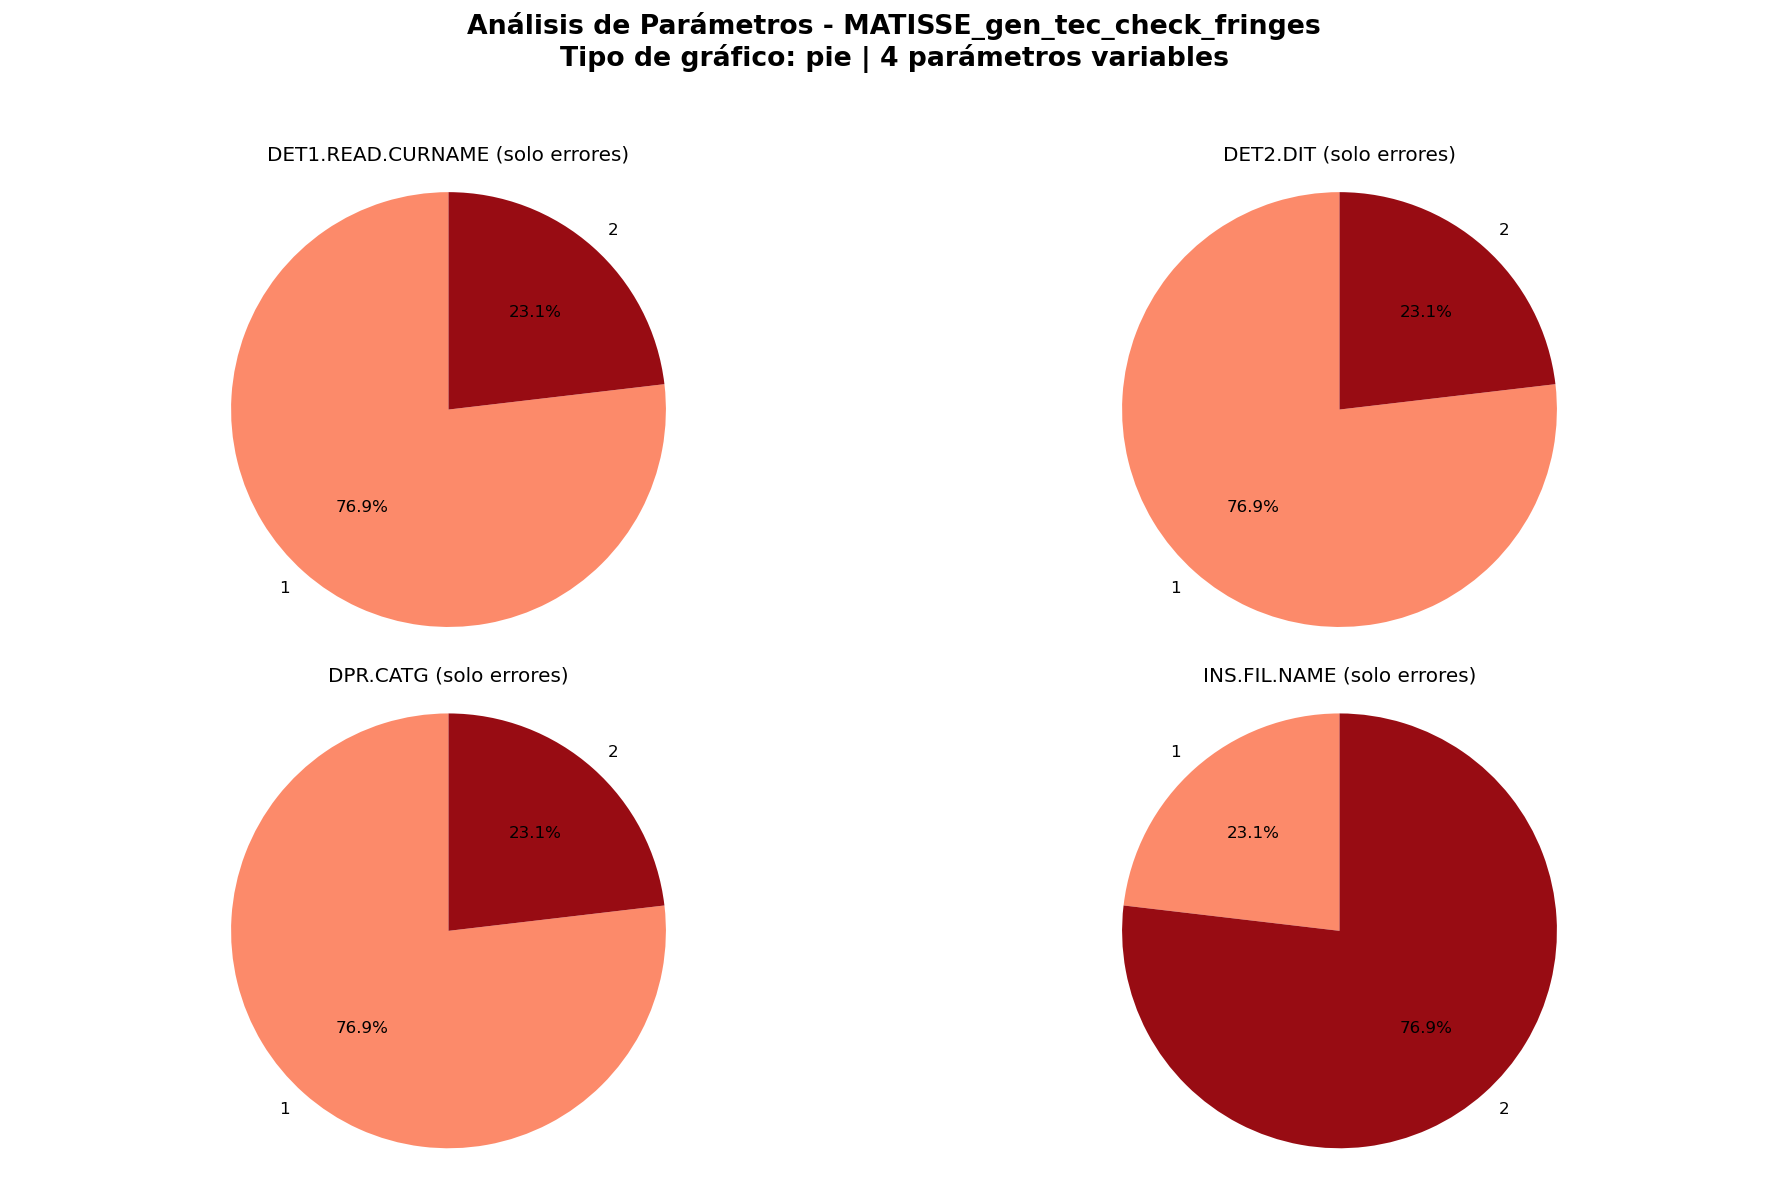

Creando gráficos tipo 'pie' para 9 parámetros NO constantes...
Parámetros constantes (omitidos): ['COU.AG.ALPHA', 'COU.AG.DELTA', 'COU.AG.EPOCH', 'COU.AG.EQUINOX', 'COU.AG.GSSOURCE', 'COU.AG.PMA', 'COU.AG.PMD', 'COU.GS.MAG', 'DEL.FT.SENSOR', 'DEL.REF.MODE', 'DEL.REF.NAME', 'DEL.REF.OPL', 'DET1.APOTYPE.VAL', 'DET1.APOX.VAL', 'DET1.APOY.VAL', 'DET1.INTERFX.VAL', 'DET1.INTERFY.VAL', 'DET1.NCOHERENT.VAL', 'DET1.NINCOHERENT.VAL', 'DET1.READ.CURNAME', 'DET1.SNRLIMIT.VAL', 'DET1.WLMAXCUT.VAL', 'DET1.WLMINCUT.VAL', 'DET2.APOTYPE.VAL', 'DET2.APOX.VAL', 'DET2.APOY.VAL', 'DET2.INTERFX.VAL', 'DET2.INTERFY.VAL', 'DET2.NCOHERENT.VAL', 'DET2.NINCOHERENT.VAL', 'DET2.READ.CURNAME', 'DET2.SNRLIMIT.VAL', 'DET2.WLMAXCUT.VAL', 'DET2.WLMINCUT.VAL', 'SEQ.ACQ.DET1.DIT', 'SEQ.ACQ.DET2.DIT', 'SEQ.ACQ.INS.FIL.NAME', 'SEQ.ACQ.INS.FIN.NAME', 'SEQ.ACQ.SKY.DURATION', 'SEQ.ACQ.TARG.DURATION', 'SEQ.DIL.WL0', 'SEQ.FS.DET1.DIT', 'SEQ.FS.DET2.DIT', 'SEQ.FS.INS.DIL.NAME', 'SEQ.FS.INS.DIN.NAME', 'SEQ.FS.INS.FIL.NAME', 'SEQ

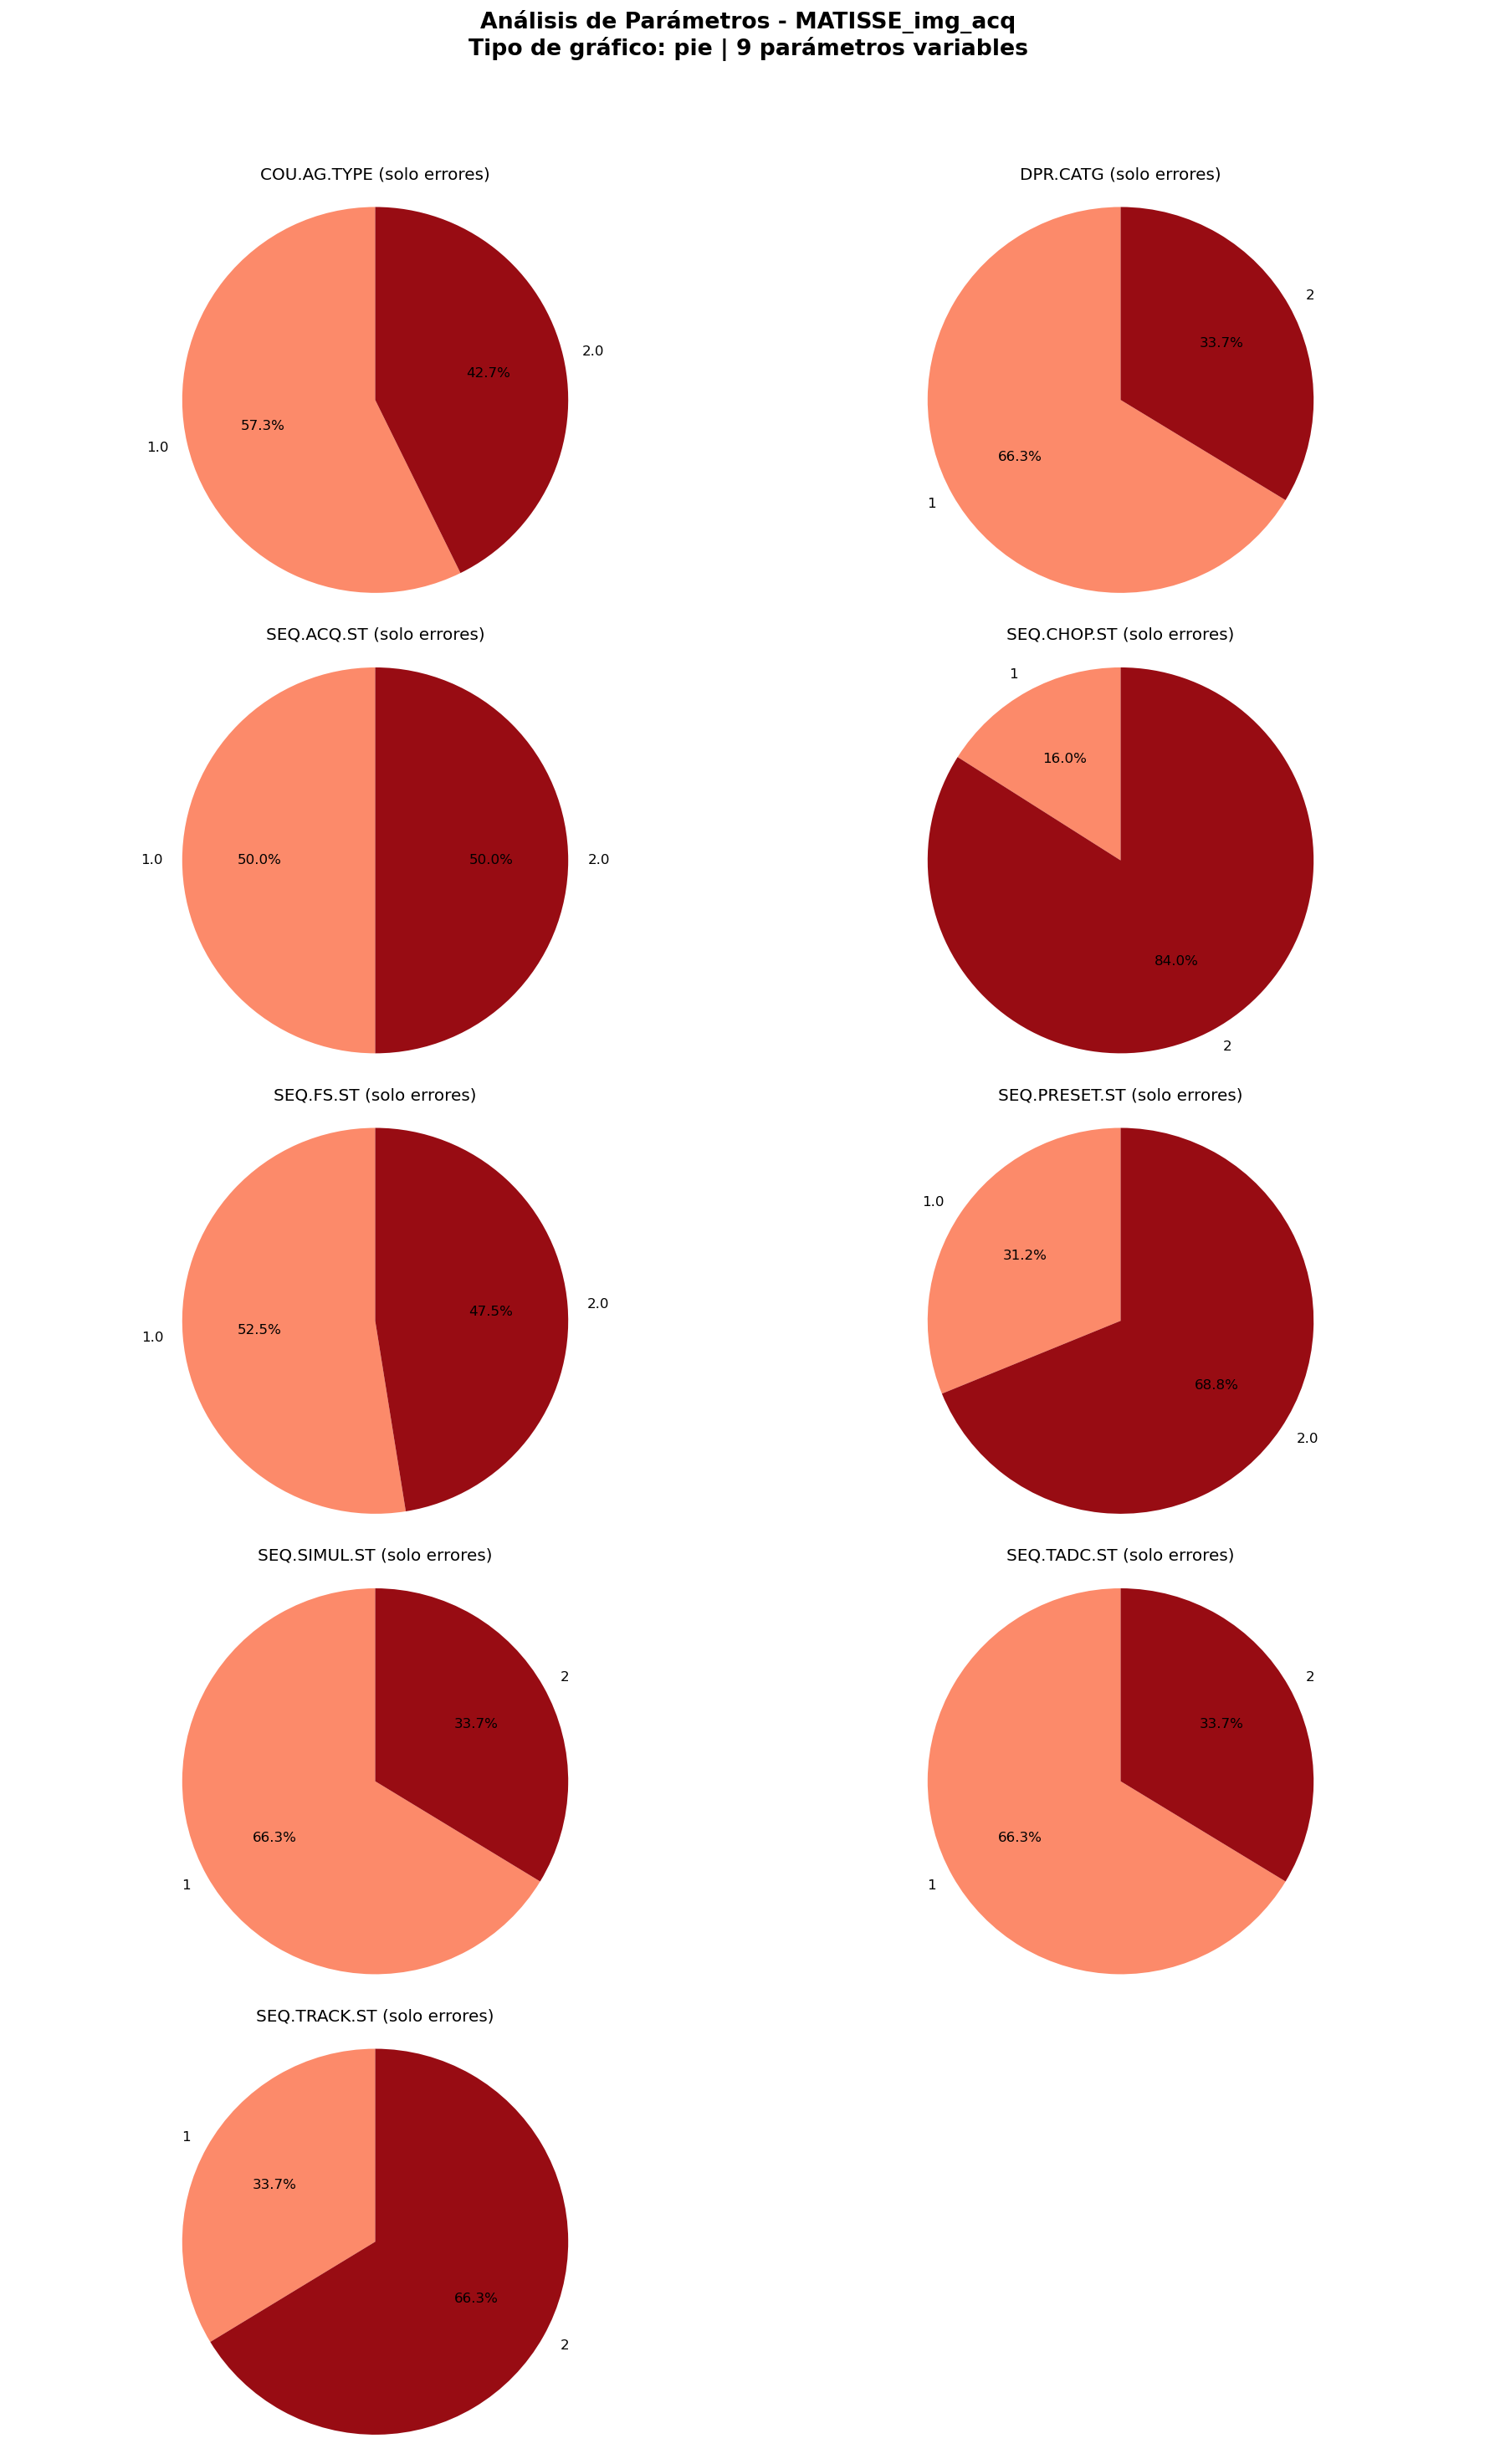

Creando gráficos tipo 'pie' para 1 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.NDIT', 'DET1.NDITSKIP', 'DET1.PERIOD', 'DET1.TDELAY', 'DET1.WIN.MTCS1', 'DET1.WIN.MTCW1', 'DET1.WIN.MTRH1', 'DET1.WIN.MTRS1', 'DPR.CATG', 'DPR.TECH', 'SEQ.DARK.INS.DIL.NAME', 'SEQ.DARK.INS.FIL.NAME', 'SEQ.DARK.INS.PIL.NAME', 'SEQ.DARK.INS.POL.NAME', 'SEQ.DARK.INS.SFL.NAME', 'SEQ.DITMAX', 'SEQ.DITMIN', 'SEQ.FLAT.INS.DIL.NAME', 'SEQ.FLAT.INS.FIL.NAME', 'SEQ.FLAT.INS.PIL.NAME', 'SEQ.FLAT.INS.POL.NAME', 'SEQ.FLAT.INS.SFL.NAME', 'SEQ.LAMP.COOLDOWN', 'SEQ.LAMP.WARMUP']


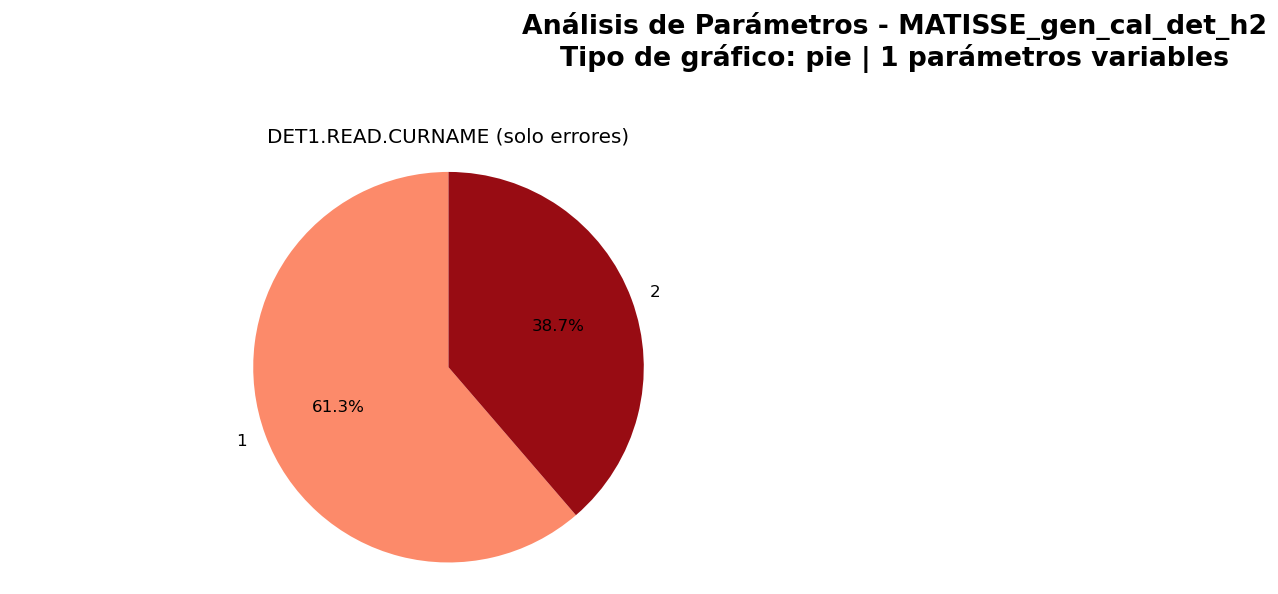

Creando gráficos tipo 'pie' para 19 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.APOTYPE.VAL', 'DET1.APOX.VAL', 'DET1.APOY.VAL', 'DET1.DIT', 'DET1.INTERFX.VAL', 'DET1.INTERFY.VAL', 'DET1.NCOHERENT.VAL', 'DET1.NINCOHERENT.VAL', 'DET1.SNRLIMIT.VAL', 'DET1.WLMAXCUT.VAL', 'DET1.WLMINCUT.VAL', 'DET2.APOTYPE.VAL', 'DET2.APOX.VAL', 'DET2.APOY.VAL', 'DET2.INTERFX.VAL', 'DET2.INTERFY.VAL', 'DET2.NCOHERENT.VAL', 'DET2.NINCOHERENT.VAL', 'DET2.READ.CURNAME', 'DET2.SNRLIMIT.VAL', 'DET2.WLMAXCUT.VAL', 'DET2.WLMINCUT.VAL', 'INS.FIN.NAME', 'INS.POL.NAME', 'INS.PON.NAME', 'INS.SFN.NAME', 'SEQ.DIL.WL0', 'SEQ.FRINGES.DURATION', 'SEQ.FRINGES.NCYCLES', 'SEQ.OPDM.L.WLMAX', 'SEQ.OPDM.N.WLMAX', 'SEQ.PHOTO.DURATION', 'SEQ.RMNREC.ST', 'SEQ.SKY.DURATION', 'SEQ.SKY.OFFS.ALPHA', 'SEQ.SKY.OFFS.DELTA', 'SEQ.TRACK.BAND', 'TEL.CHOP.FREQ', 'TEL.CHOP.POSANG', 'TEL.CHOP.PVRATIO', 'TEL.CHOP.THROW']


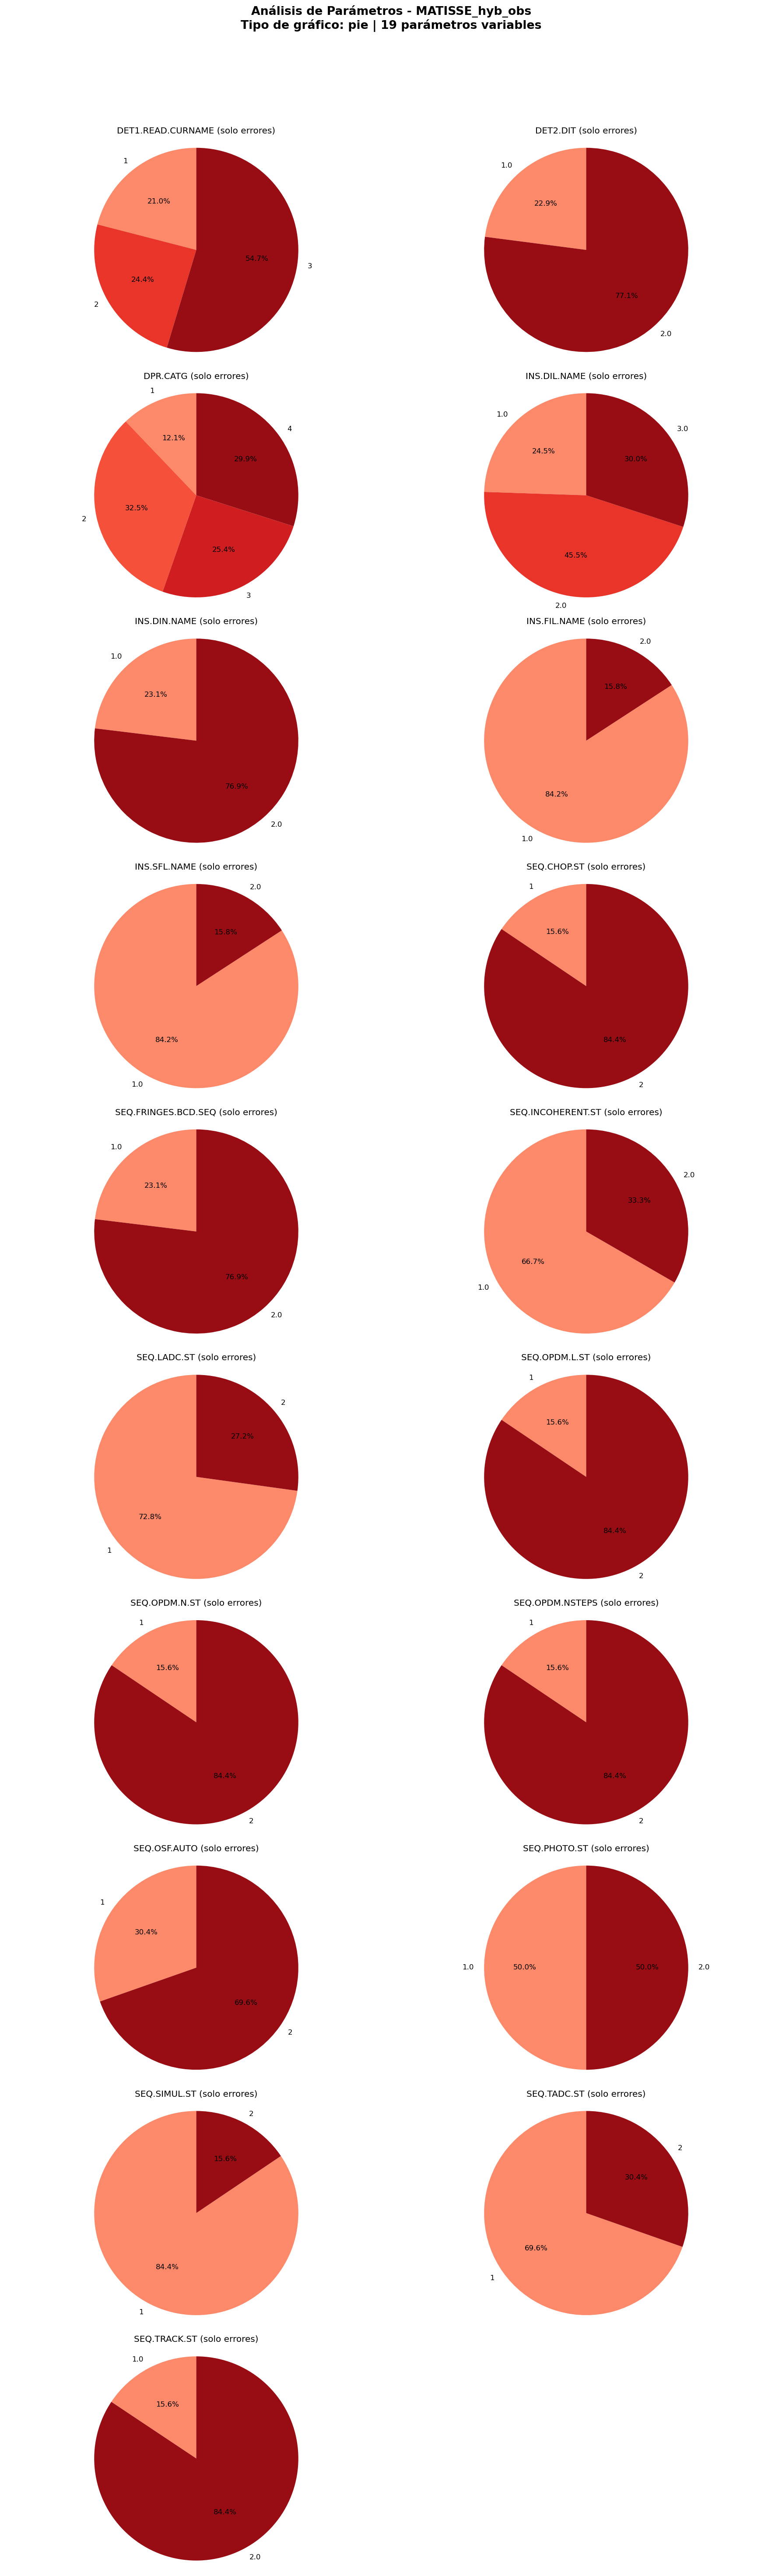

Creando gráficos tipo 'pie' para 9 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.APOTYPE.VAL', 'DET1.APOX.VAL', 'DET1.APOY.VAL', 'DET1.DIT', 'DET1.INTERFX.VAL', 'DET1.INTERFY.VAL', 'DET1.NCOHERENT.VAL', 'DET1.NDIT', 'DET1.NINCOHERENT.VAL', 'DET1.SNRLIMIT.VAL', 'DET1.WLMAXCUT.VAL', 'DET1.WLMINCUT.VAL', 'DET2.APOTYPE.VAL', 'DET2.APOX.VAL', 'DET2.APOY.VAL', 'DET2.INTERFX.VAL', 'DET2.INTERFY.VAL', 'DET2.NCOHERENT.VAL', 'DET2.NDIT', 'DET2.NINCOHERENT.VAL', 'DET2.SNRLIMIT.VAL', 'DET2.WLMAXCUT.VAL', 'DET2.WLMINCUT.VAL', 'DPR.TECH', 'INS.FIN.NAME', 'INS.PIL.NAME', 'INS.PIN.NAME', 'INS.POL.NAME', 'INS.PON.NAME', 'INS.SFL.NAME', 'INS.SFN.NAME', 'SEQ.ALIGN.MODE', 'SEQ.INSTALL_CFG', 'SEQ.SIMUL.DIR', 'SEQ.SIMUL.ST']


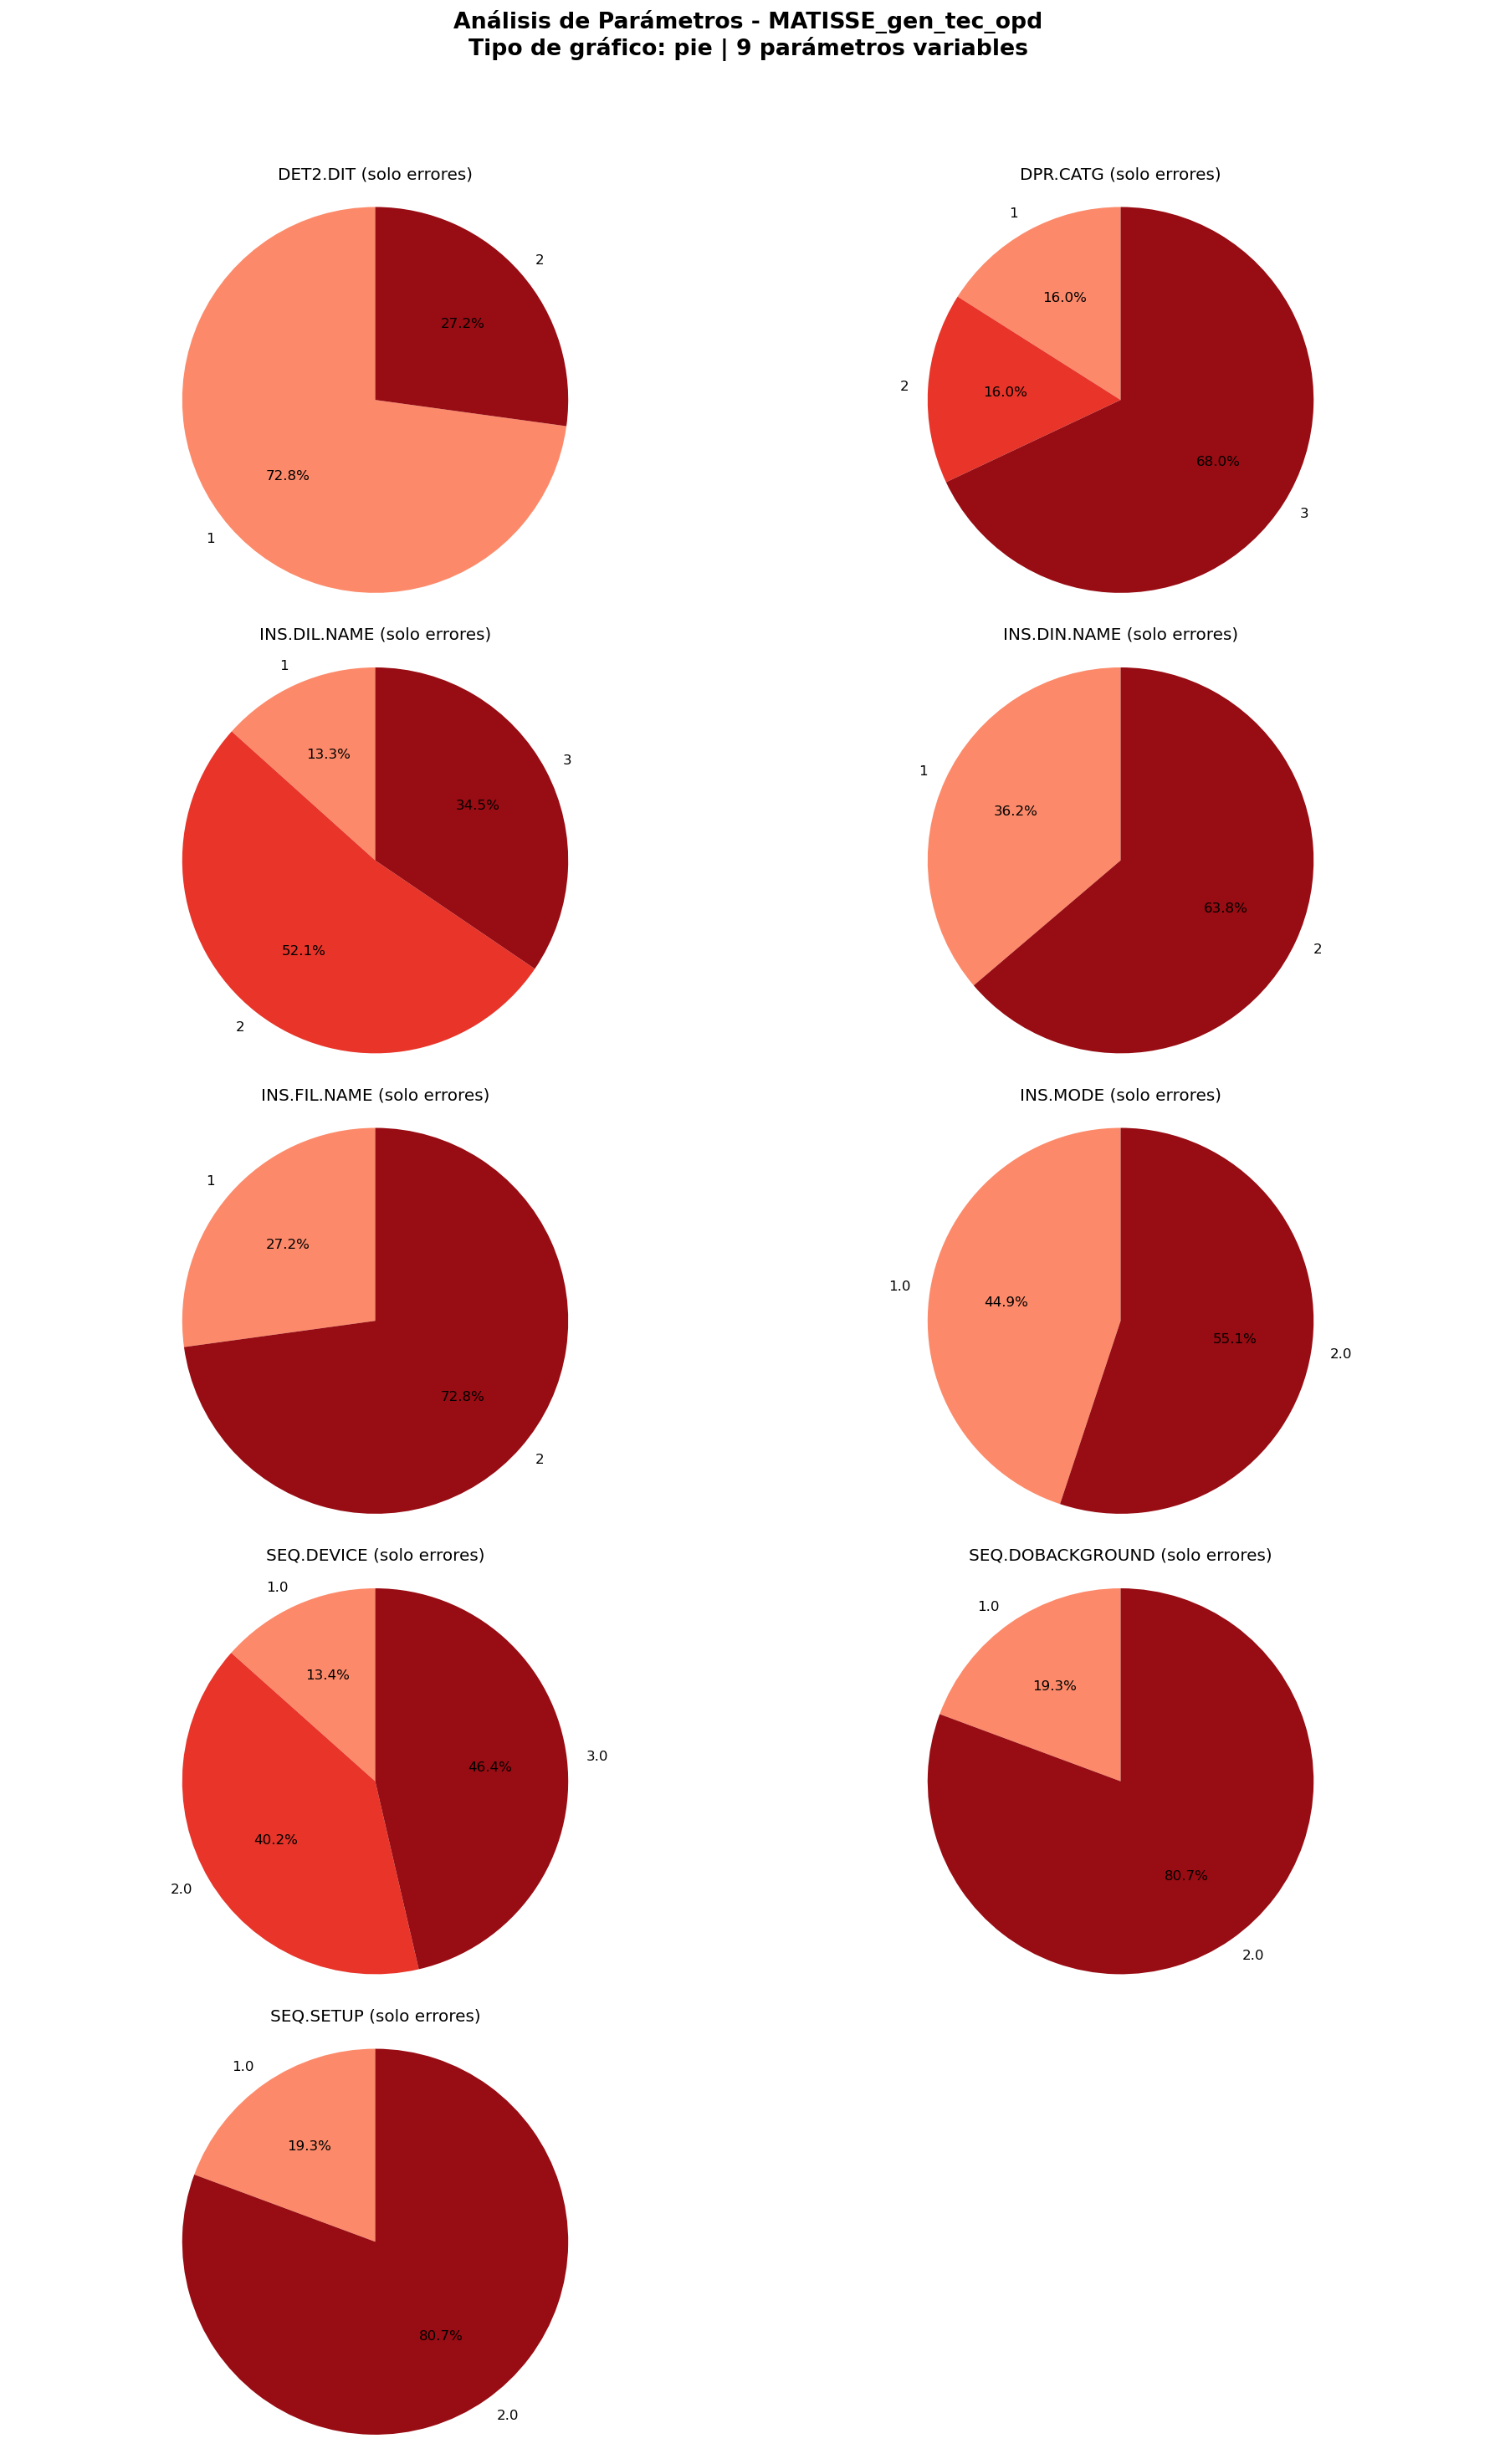

Creando gráficos tipo 'pie' para 7 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.APOTYPE.VAL', 'DET1.APOX.VAL', 'DET1.APOY.VAL', 'DET1.DIT', 'DET1.INTERFX.VAL', 'DET1.INTERFY.VAL', 'DET1.NCOHERENT.VAL', 'DET1.NDIT', 'DET1.NINCOHERENT.VAL', 'DET1.SNRLIMIT.VAL', 'DET1.WLMAXCUT.VAL', 'DET1.WLMINCUT.VAL', 'DET2.APOTYPE.VAL', 'DET2.APOX.VAL', 'DET2.APOY.VAL', 'DET2.DIT', 'DET2.INTERFX.VAL', 'DET2.INTERFY.VAL', 'DET2.NCOHERENT.VAL', 'DET2.NDIT', 'DET2.NINCOHERENT.VAL', 'DET2.READ.CURNAME', 'DET2.SNRLIMIT.VAL', 'DET2.WLMAXCUT.VAL', 'DET2.WLMINCUT.VAL', 'DPR.CATG', 'DPR.TECH', 'INS.FIN.NAME', 'INS.PIL.NAME', 'INS.POL.NAME', 'INS.PON.NAME', 'SEQ.DIL.WL0']


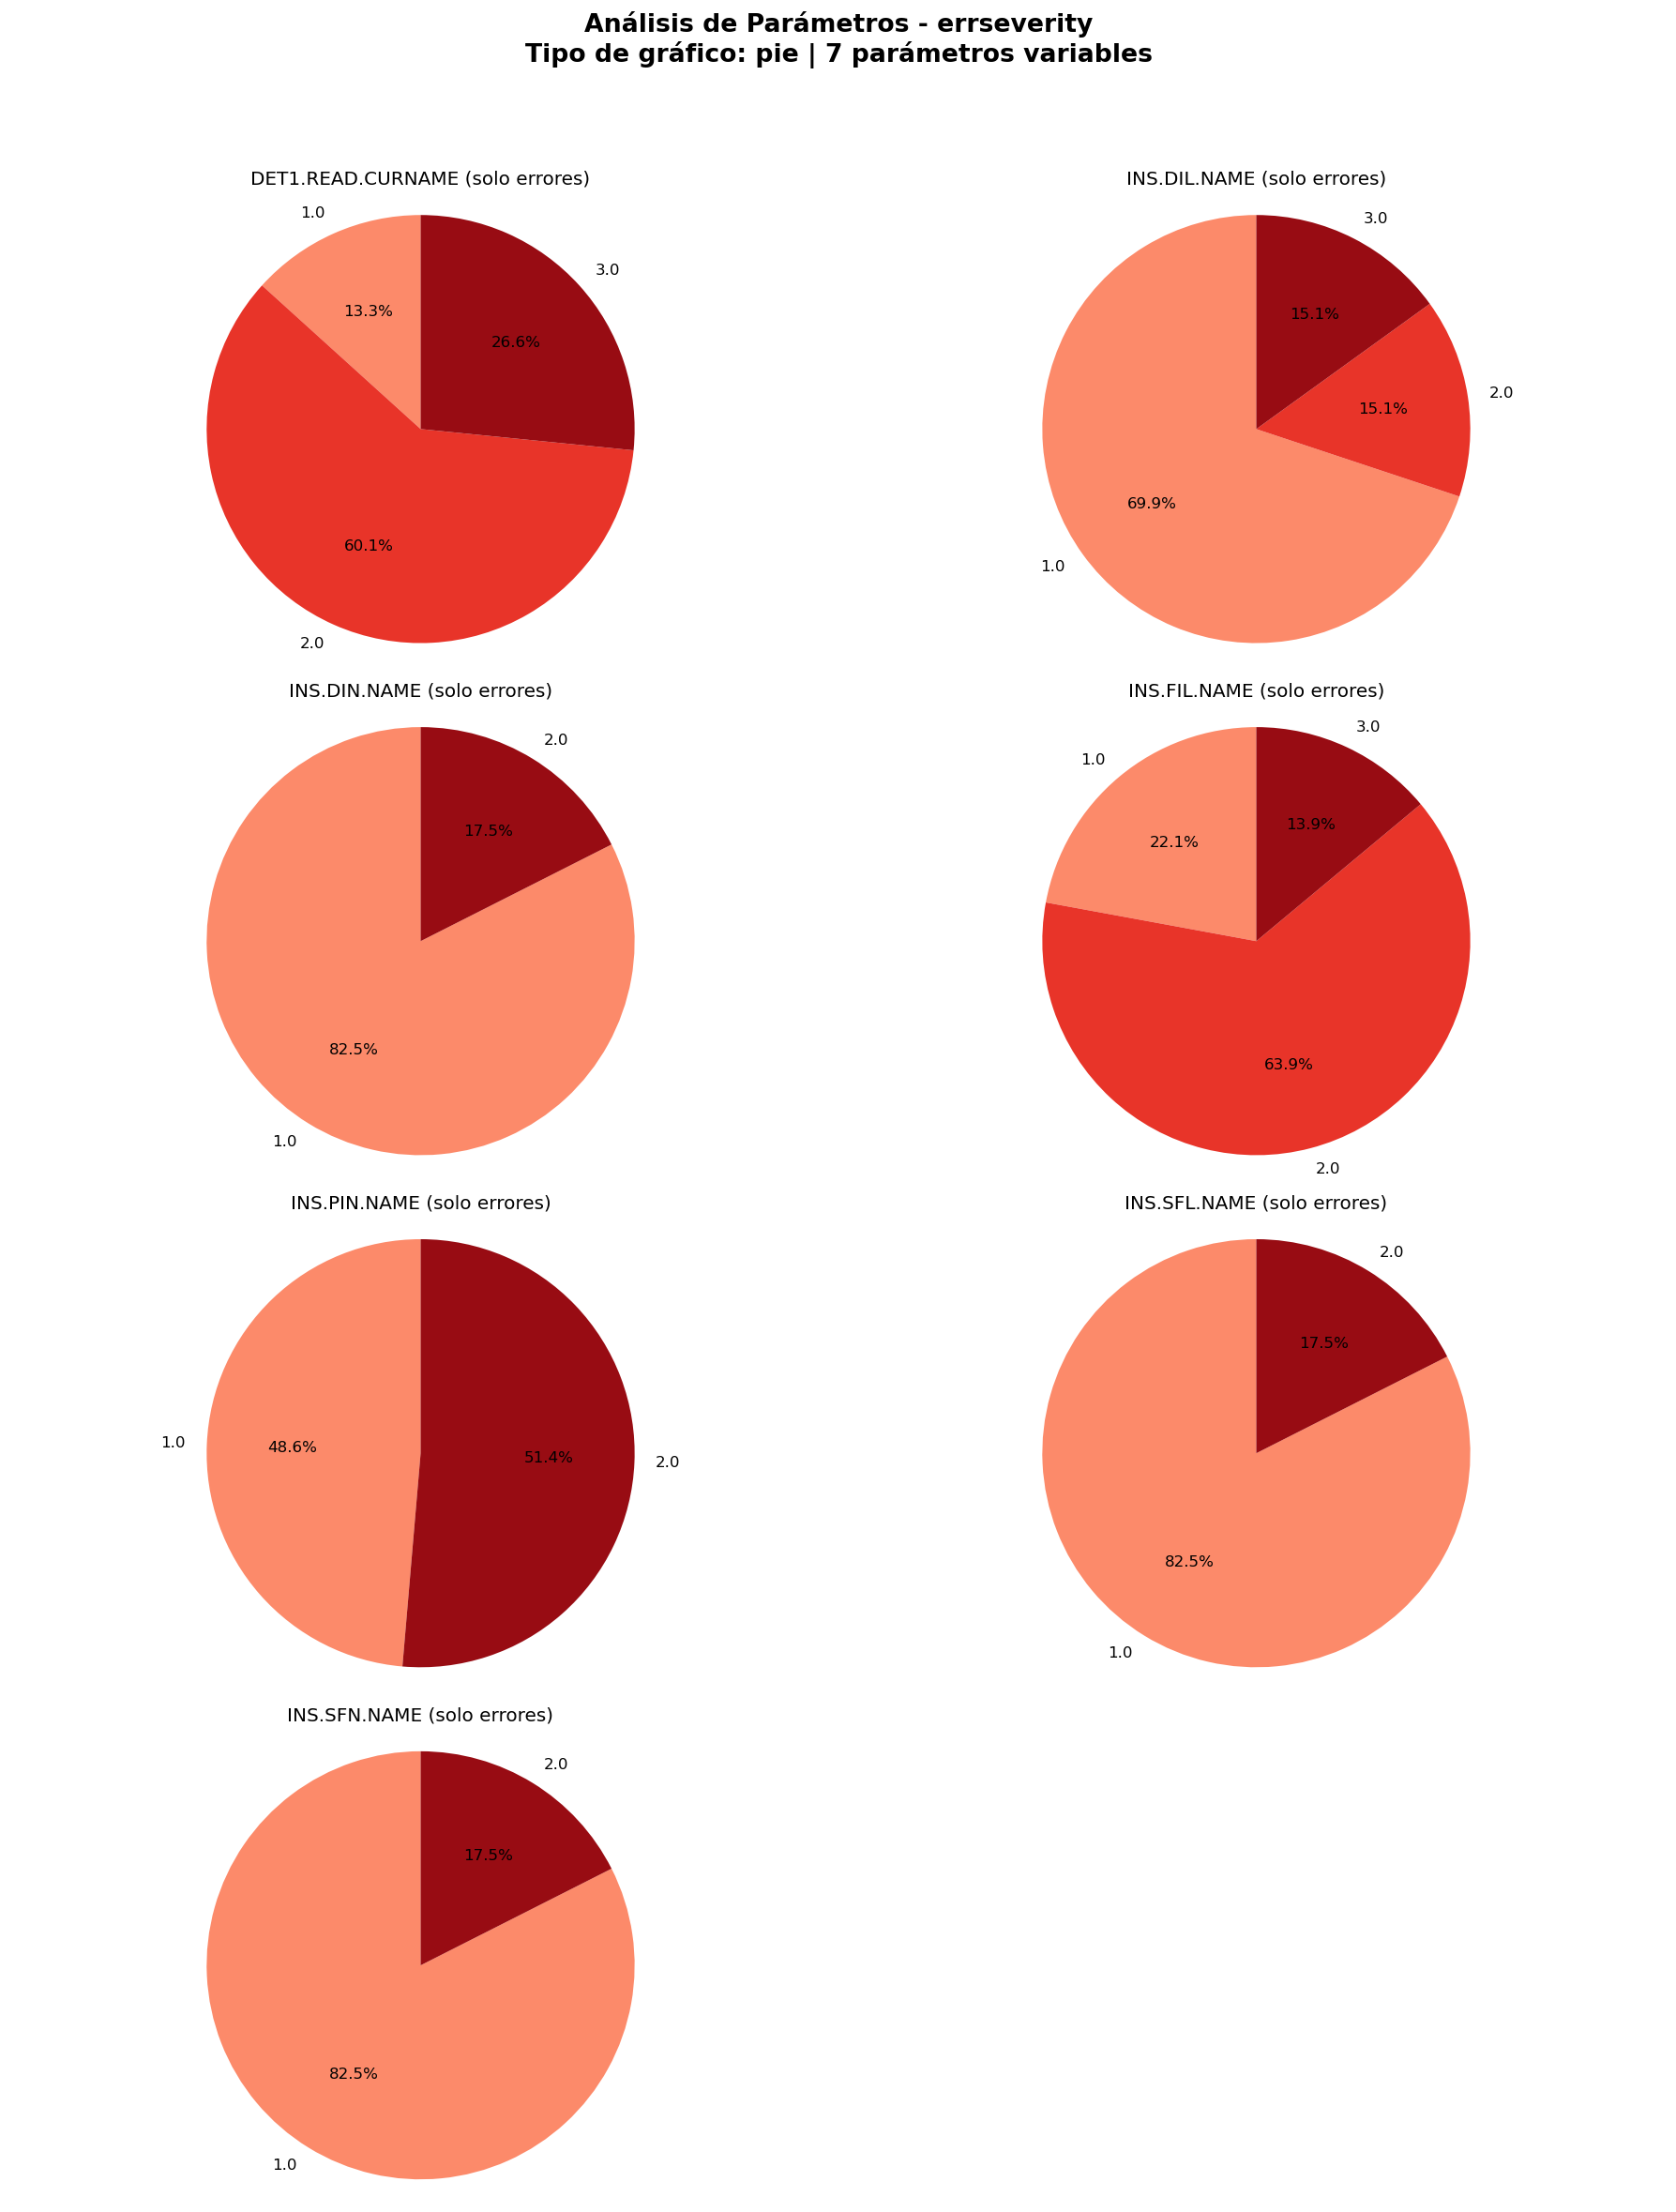

Creando gráficos tipo 'pie' para 3 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.DIT', 'DET1.NDIT', 'DET2.DIT', 'DET2.NDIT', 'DET2.READ.CURNAME', 'DPR.CATG', 'INS.DIL.NAME', 'INS.DIN.NAME', 'INS.POL.NAME', 'INS.PON.NAME', 'SEQ.SIMUL.ST']


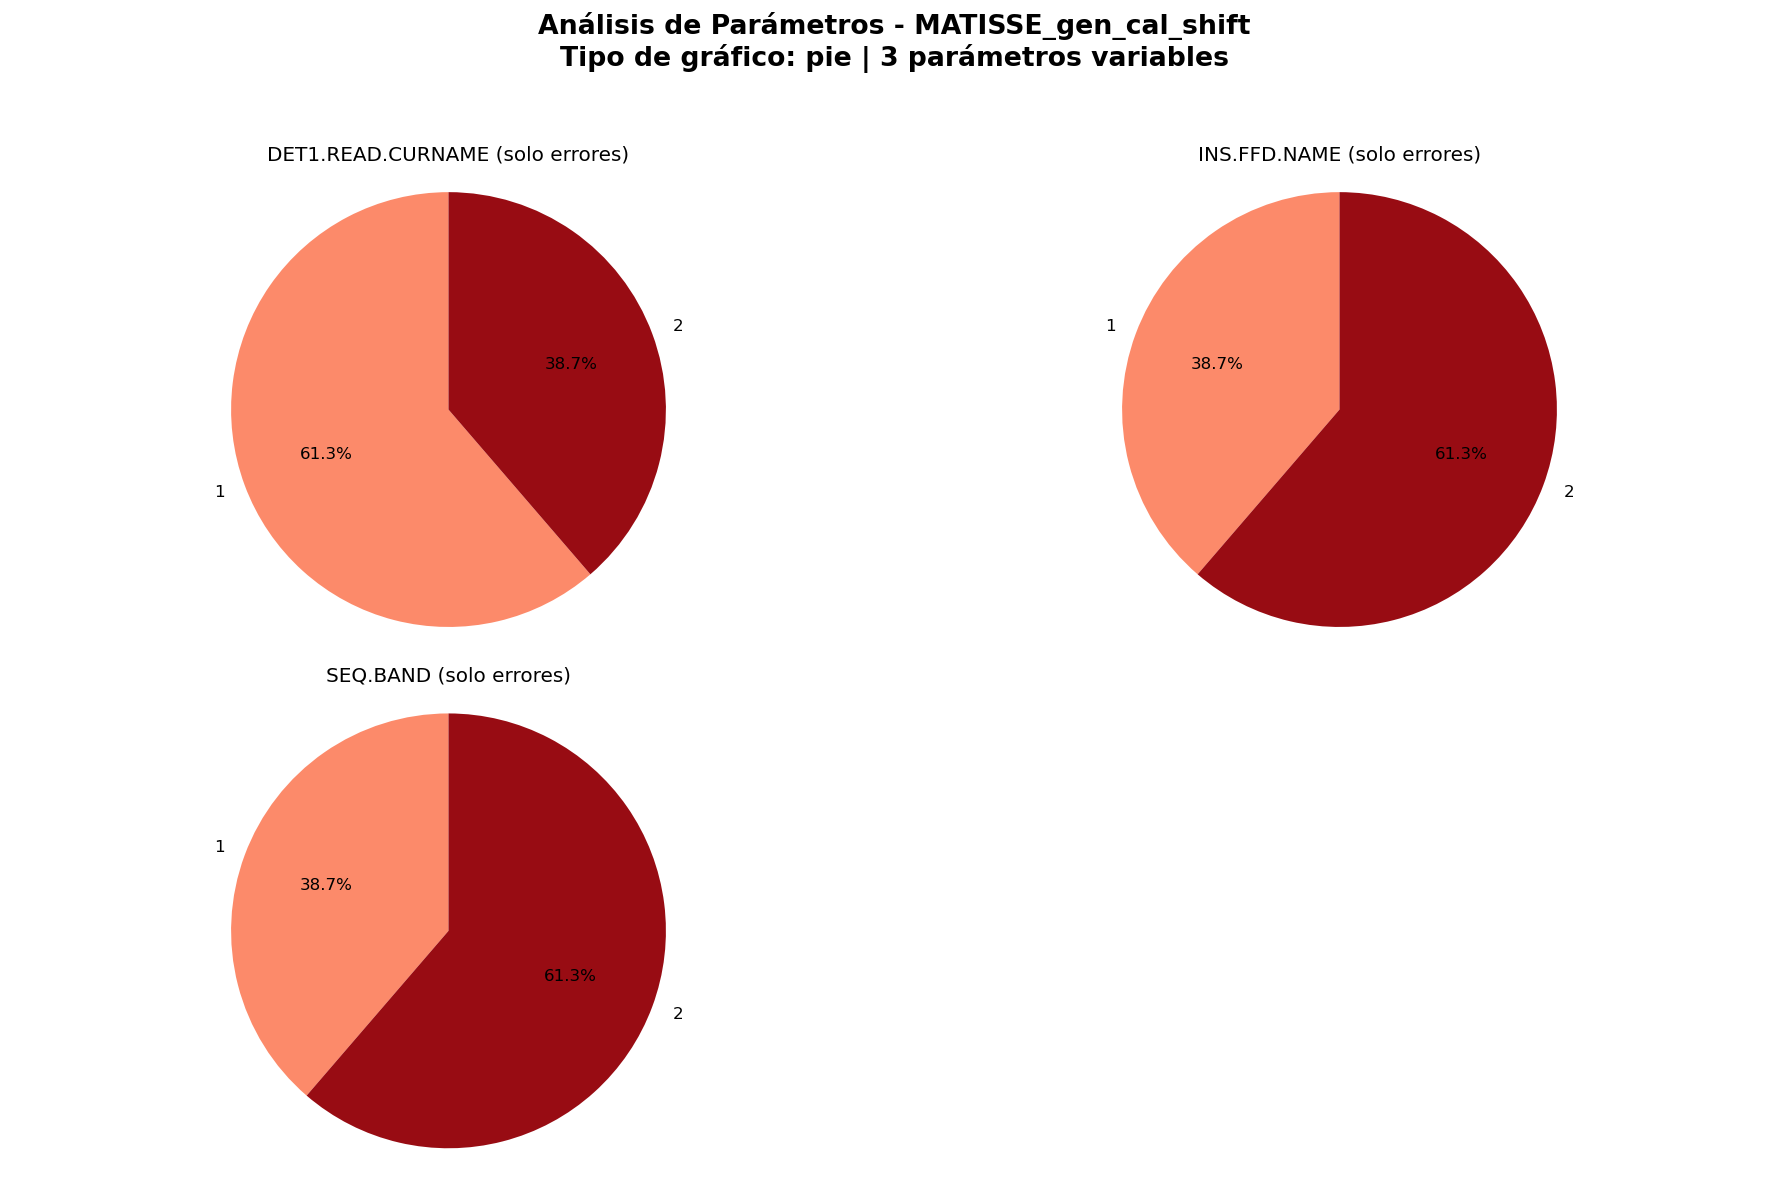

Creando gráficos tipo 'pie' para 1 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.DIT', 'DET1.NDIT', 'DET2.DIT', 'DET2.NDIT', 'DET2.READ.CURNAME', 'DPR.CATG', 'DPR.TECH', 'INS.DIL.NAME', 'INS.DIN.NAME', 'INS.FIL.NAME', 'INS.FIN.NAME', 'INS.POL.NAME', 'INS.PON.NAME', 'INS.SFL.NAME', 'INS.SFN.NAME', 'SEQ.BAND', 'SEQ.SIMUL.ST']


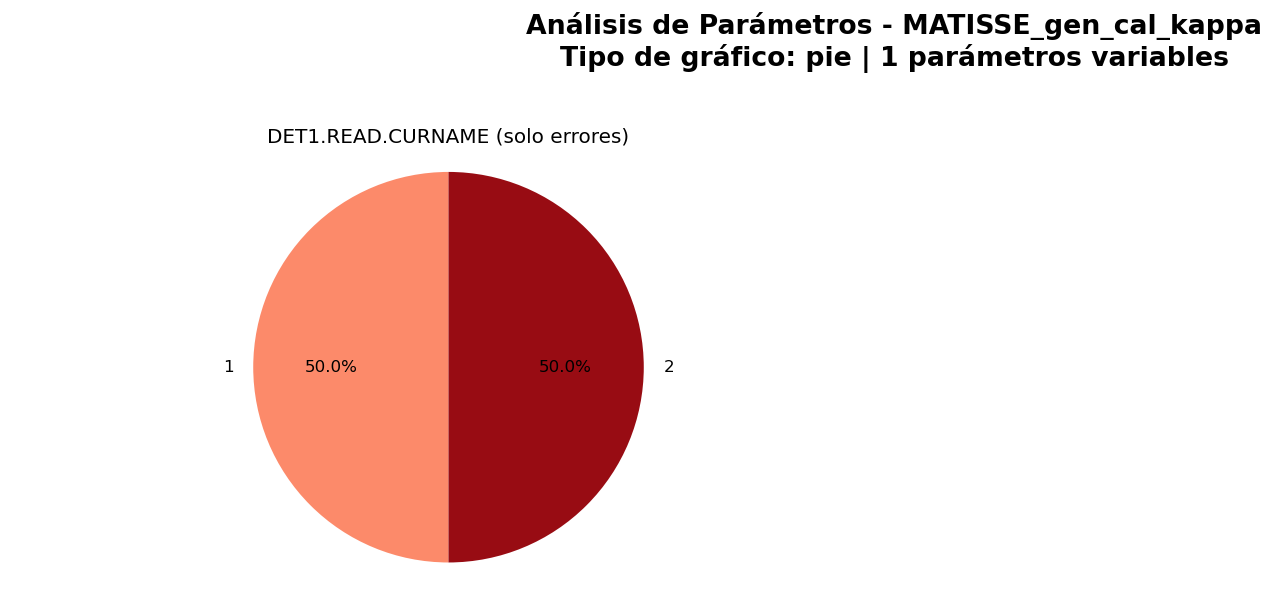

Creando gráficos tipo 'pie' para 0 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.DIT', 'DET1.NDIT', 'DET1.READ.CURNAME', 'DET2.DIT', 'DET2.NDIT', 'DET2.READ.CURNAME', 'DPR.CATG', 'DPR.TECH', 'INS.DIL.NAME', 'INS.DIN.NAME', 'INS.FIL.NAME', 'INS.FIN.NAME', 'INS.PIL.NAME', 'INS.PIN.NAME', 'INS.POL.NAME', 'INS.PON.NAME', 'INS.SFL.NAME', 'INS.SFN.NAME', 'SEQ.BAND.LIST', 'SEQ.BEAMS', 'SEQ.DEV.LIST', 'SEQ.PZT.END', 'SEQ.PZT.START', 'SEQ.PZT.STEP', 'SEQ.SIMUL.ST']
Todos los parámetros son constantes. No se generarán gráficos.
Creando gráficos tipo 'pie' para 0 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.DIT', 'DET1.NDIT', 'DET1.NDITSKIP', 'DET1.PERIOD', 'DET1.READ.CURNAME', 'DET1.TDELAY', 'DET1.WIN.MTCS.LIST', 'DET1.WIN.MTCW.LIST', 'DET1.WIN.MTRH.LIST', 'DET1.WIN.MTRS.LIST', 'DET1.WIN.NCOL', 'DET1.WIN.NROW', 'DET2.DIT', 'DET2.NDIT', 'DET2.NDITSKIP', 'DET2.PERIOD', 'DET2.READ.CURNAME', 'DET2.TDELAY', 'DET2.WIN.MTCS.LIST', 'DET2.WIN.MTCW.LIST', 'DE

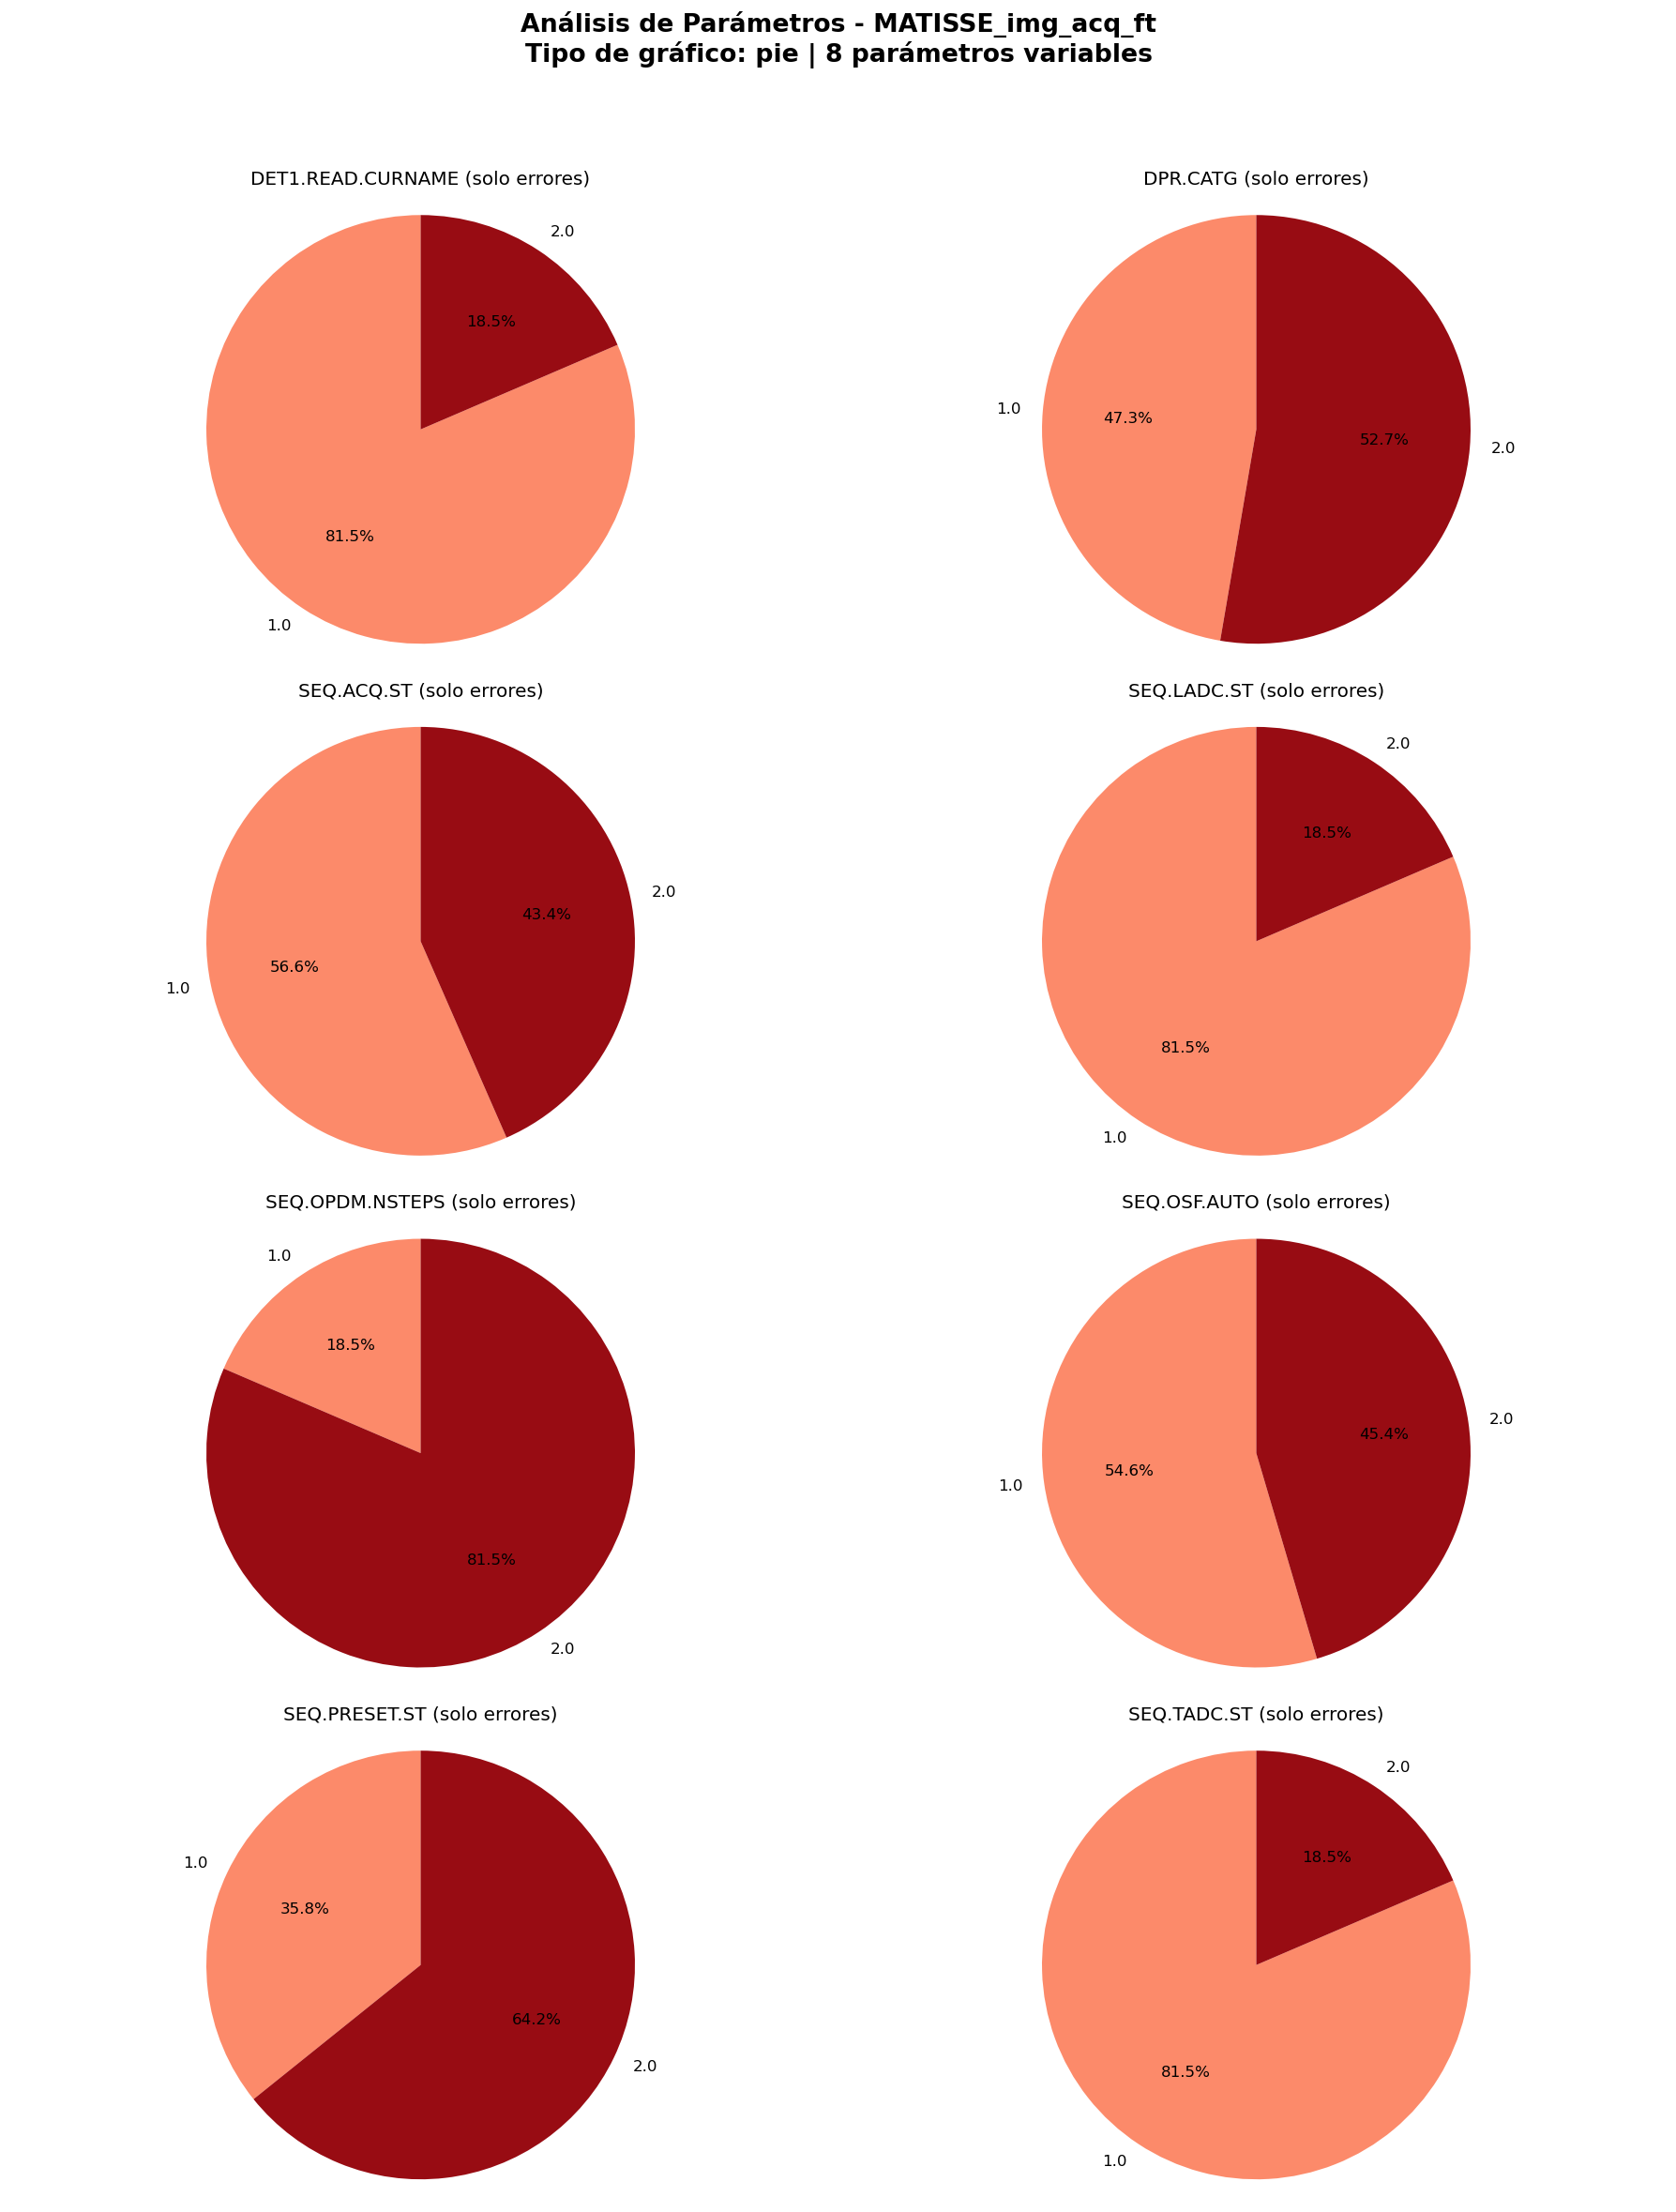

Creando gráficos tipo 'pie' para 5 parámetros NO constantes...
Parámetros constantes (omitidos): ['DPR.CATG', 'INS.DIN.NAME', 'INS.PIL.NAME', 'INS.SFL.NAME', 'INS.SFN.NAME', 'SEQ.DET.TRIG.ST', 'SEQ.DIL.WL0', 'SEQ.IMG.DIT', 'SEQ.IMG.NDIT']


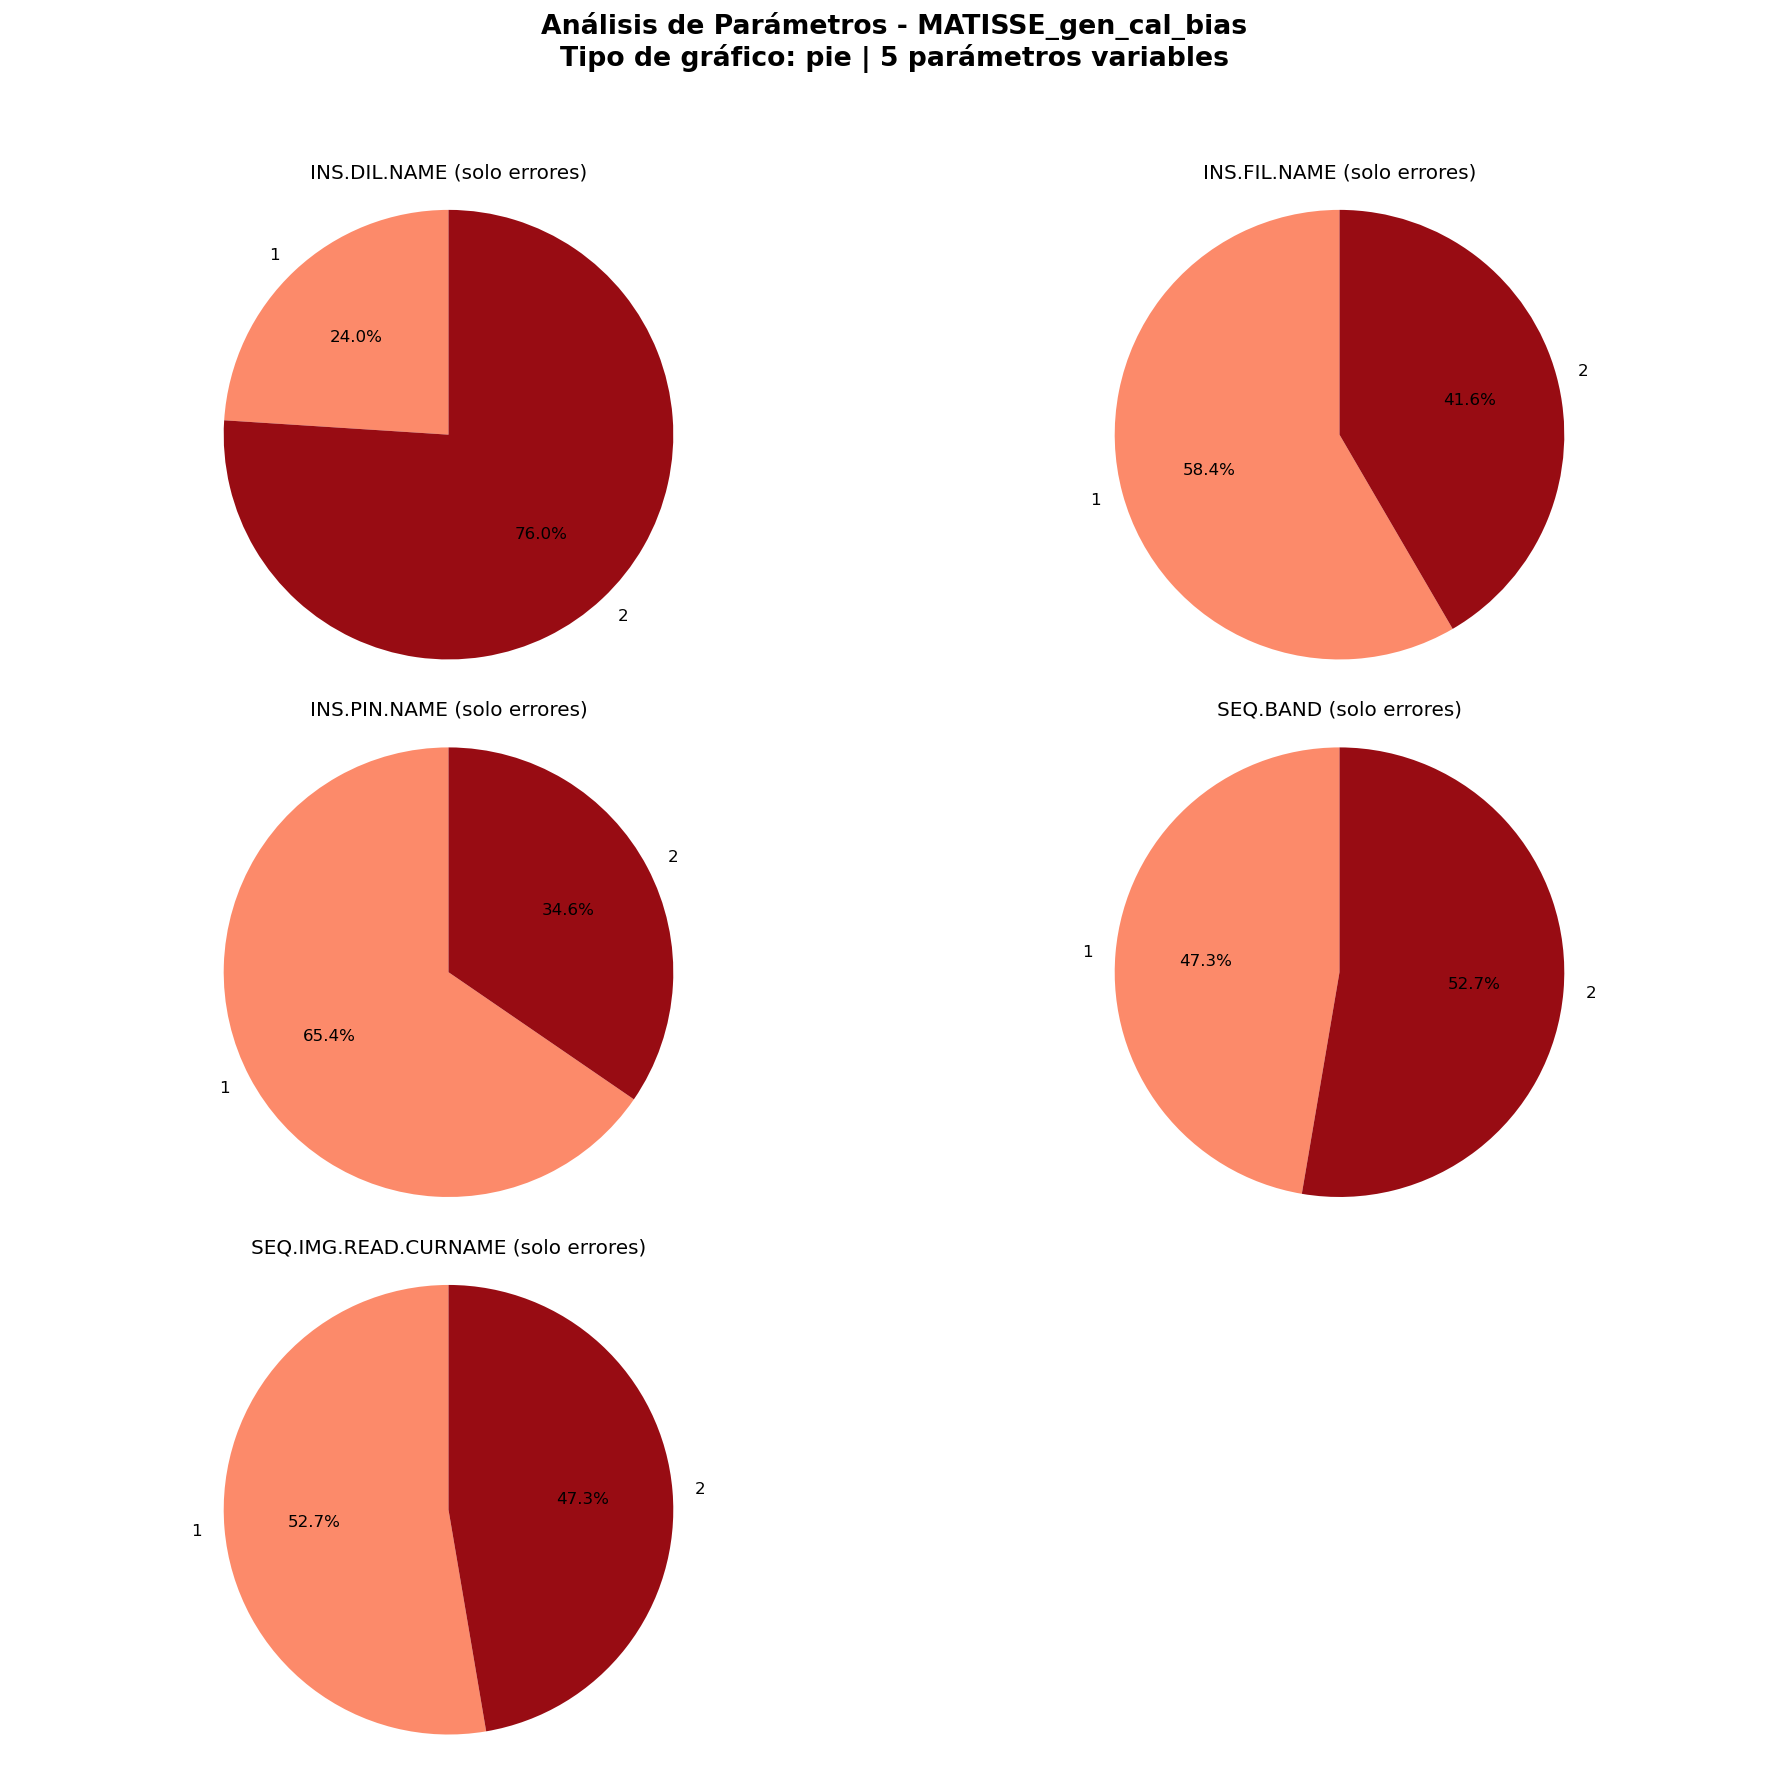

Creando gráficos tipo 'pie' para 1 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET2.DIT', 'DET2.NDIT', 'DET2.NDITSKIP', 'DET2.PERIOD', 'DET2.TDELAY', 'DET2.WIN.MTCS1', 'DET2.WIN.MTCW1', 'DET2.WIN.MTRH1', 'DET2.WIN.MTRS1', 'DPR.CATG', 'DPR.TECH', 'SEQ.DARK.INS.DIN.NAME', 'SEQ.DARK.INS.FIN.NAME', 'SEQ.DARK.INS.PIN.NAME', 'SEQ.DARK.INS.PON.NAME', 'SEQ.DARK.INS.SFN.NAME', 'SEQ.FLAT.INS.DIN.NAME', 'SEQ.FLAT.INS.FIN.NAME', 'SEQ.FLAT.INS.PIN.NAME', 'SEQ.FLAT.INS.PON.NAME', 'SEQ.FLAT.INS.SFN.NAME', 'SEQ.LAMP.COOLDOWN', 'SEQ.LAMP.WARMUP']


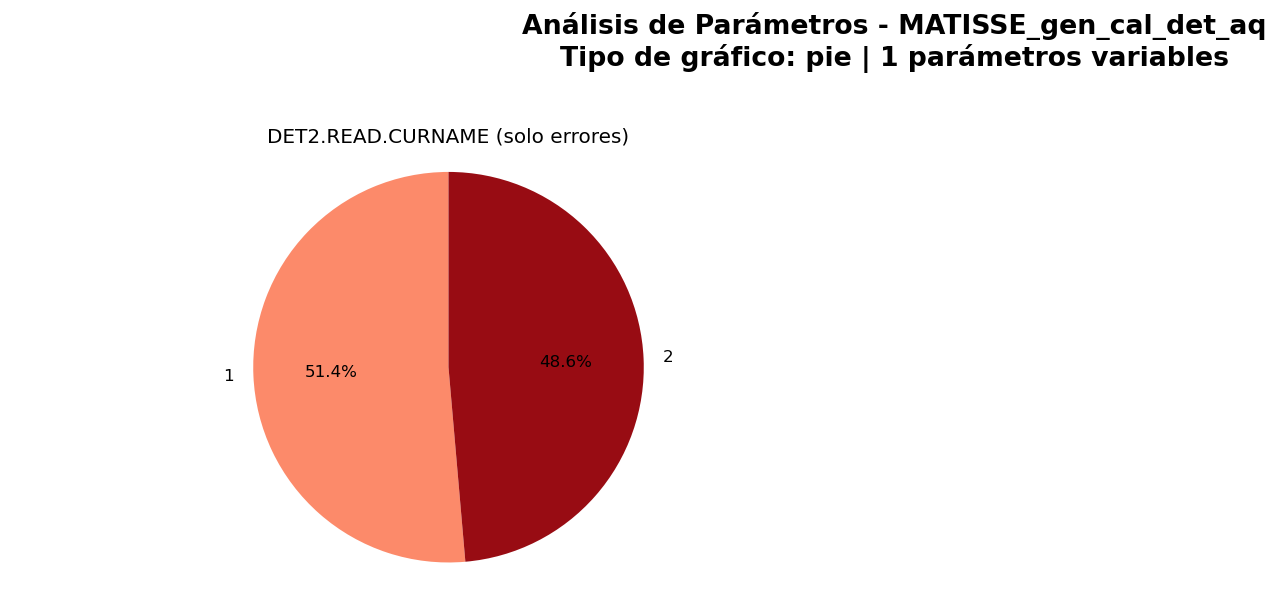

Creando gráficos tipo 'pie' para 5 parámetros NO constantes...
Parámetros constantes (omitidos): ['DPR.CATG', 'DPR.TECH', 'SEQ.IMG.DIT', 'SEQ.IMG.NDIT', 'SEQ.IMG.REF.DIT', 'SEQ.IMG.REF.NDIT', 'SEQ.PUP.DIT', 'SEQ.PUP.NDIT', 'SEQ.PUP.REF.DIT', 'SEQ.PUP.REF.NDIT', 'SEQ.SIMUL.ST']


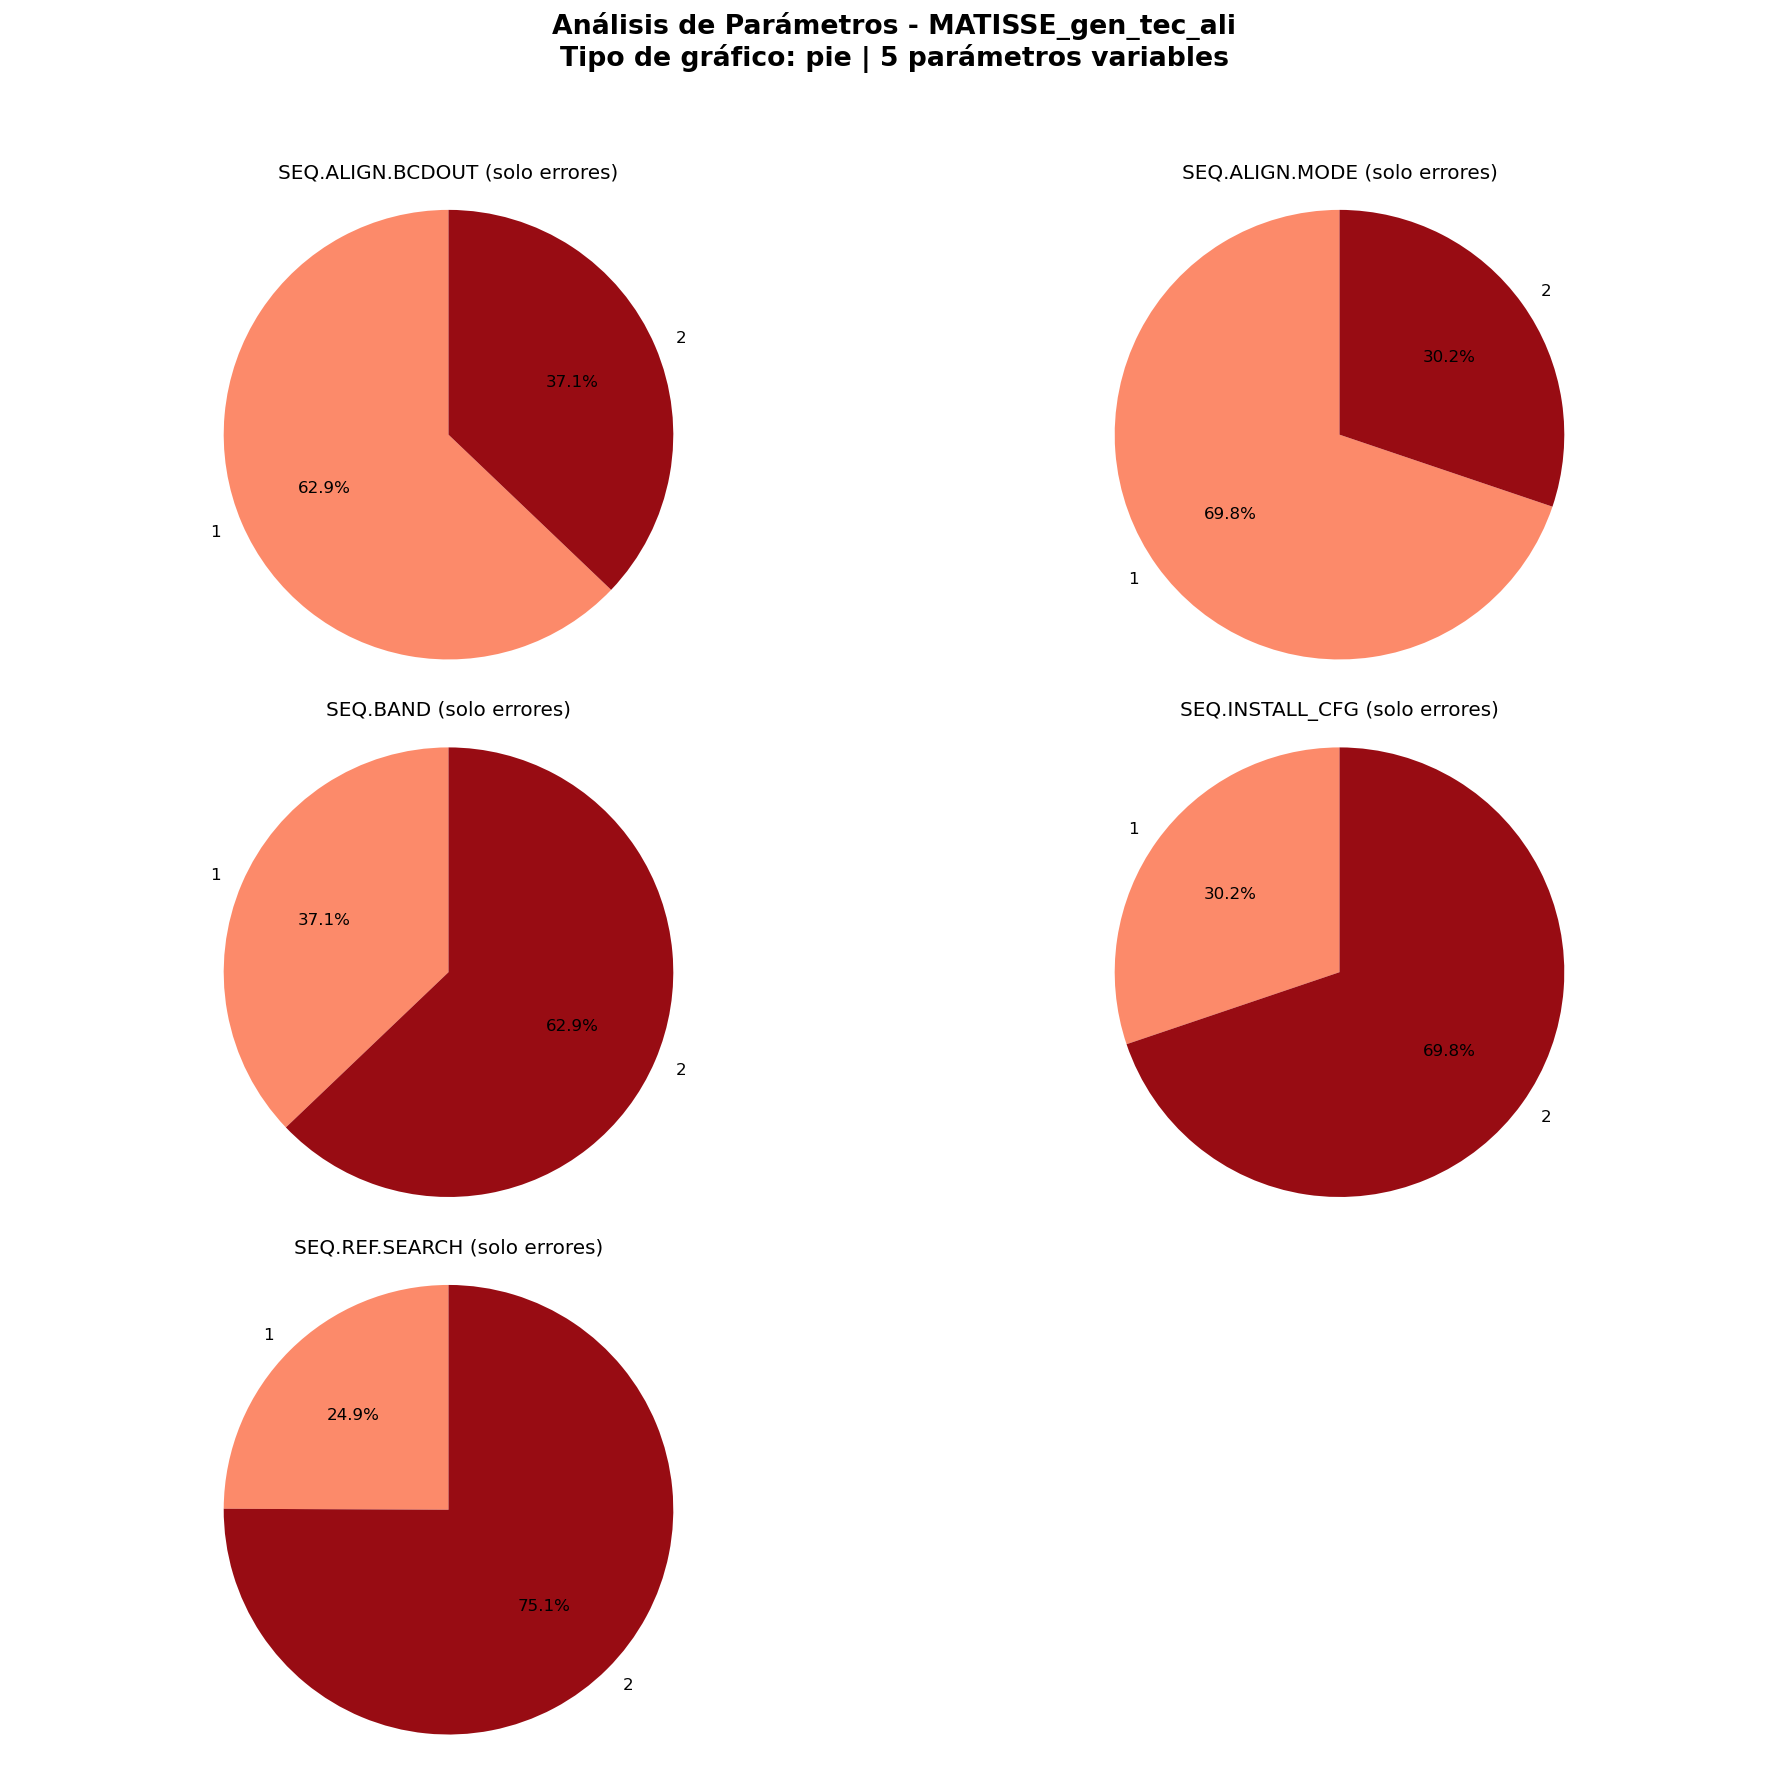

Creando gráficos tipo 'pie' para 0 parámetros NO constantes...
Parámetros constantes (omitidos): ['DET1.APOTYPE.VAL', 'DET1.APOX.VAL', 'DET1.APOY.VAL', 'DET1.DIT', 'DET1.INTERFX.VAL', 'DET1.INTERFY.VAL', 'DET1.NCOHERENT.VAL', 'DET1.NINCOHERENT.VAL', 'DET1.READ.CURNAME', 'DET1.SNRLIMIT.VAL', 'DET1.WLMAXCUT.VAL', 'DET1.WLMINCUT.VAL', 'DET2.APOTYPE.VAL', 'DET2.APOX.VAL', 'DET2.APOY.VAL', 'DET2.DIT', 'DET2.INTERFX.VAL', 'DET2.INTERFY.VAL', 'DET2.NCOHERENT.VAL', 'DET2.NINCOHERENT.VAL', 'DET2.READ.CURNAME', 'DET2.SNRLIMIT.VAL', 'DET2.WLMAXCUT.VAL', 'DET2.WLMINCUT.VAL', 'DPR.CATG', 'INS.DIL.NAME', 'INS.DIN.NAME', 'INS.FIL.NAME', 'INS.FIN.NAME', 'INS.POL.NAME', 'INS.PON.NAME', 'INS.SFL.NAME', 'INS.SFN.NAME', 'SEQ.CHOP.ST', 'SEQ.DARK.DURATION', 'SEQ.DIL.WL0', 'SEQ.FRINGES.BCD.SEQ', 'SEQ.FRINGES.DURATION', 'SEQ.FRINGES.NCYCLES', 'SEQ.INCOHERENT.ST', 'SEQ.OBS.MODE', 'SEQ.OPDM.L.ST', 'SEQ.OPDM.L.WLMAX', 'SEQ.OPDM.N.ST', 'SEQ.OPDM.N.WLMAX', 'SEQ.OPDM.NSTEPS', 'SEQ.OSF.AUTO', 'SEQ.PHOTO.DURATION', '

In [12]:
THRESHOLD_NAN = 0.5

for tpl_id_str, df_err_codified in codified_strval_err_dfs.items():
    if df_err_codified is None or df_err_codified.empty:
        print(f"{tpl_id_str}: DataFrame vacío o inexistente. Se omite.")
        continue

    df_err_cleaned = df_err_codified.loc[:, df_err_codified.isna().mean() < THRESHOLD_NAN]
    df_err_cleaned = df_err_cleaned.loc[df_err_cleaned.isna().mean(axis=1) < THRESHOLD_NAN, :]

    if df_err_cleaned.empty:
        print(f"{tpl_id_str}: DataFrame vacío después de la limpieza. Se omite.")
        continue

    columns = sorted(df_err_cleaned.columns)
    if not columns:
        print(f"{tpl_id_str}: No hay columnas válidas después de la limpieza.")
        continue


    graficos_por_columna(
        None,  # No hay dataset OK
        df_err_cleaned[columns],
        nombre_archivo=tpl_id_str,
        tipo="pie",
        use_log=True
    )



## 3. Normalización, Reducción de Dimensionalidad (t-SNE/UMAP) y Clustering (DBSCAN)



Se normalizan con Min-Max los datos, reducción de dimensionalidad con t-SNE y UMAP, y clustering DBSCAN.


Clustering conjunto (sin usar etiqueta) → MATISSE_hyb_obs
DBSCAN params: {'eps': np.float32(11.760191), 'min_samples': 10, 'n': 1612, 'p': 17}
origen   ERR   OK
cluster          
-1         0   48
 0         0   77
 1         1   54
 2         5   62
 3         0   24
 4         0   53
 5         0   29
 6         0   24
 7         7  118
 8         0   31
 9         1   34
 10        5  140
 11        0   13
 12        3   29
 13        1   30
 14        0   37
 15        0   19
 16       11  331
 17        1   73
 18        1   37
 19        0   48
 20        1   10
 21        0   17
 22        1   32
 23        3  101
 24        0   17
 25        0   14
 26        0   19
 27        0   22
 28        2   26


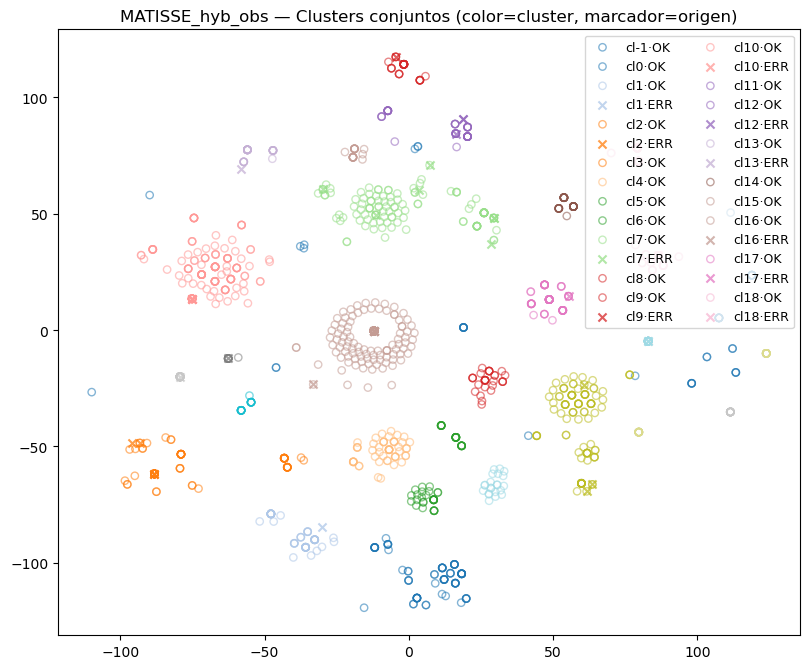


Clustering conjunto (sin usar etiqueta) → MATISSE_img_acq
DBSCAN params: {'eps': np.float32(10.970831), 'min_samples': 10, 'n': 1463, 'p': 23}
origen   ERR   OK
cluster          
-1         0   12
 0         0   62
 1         4  142
 2         0   12
 3         1   13
 4         1   62
 5         0   53
 6         1   39
 7        18  777
 8         0   10
 9         1   50
 10        1   33
 11        1   25
 12        1   30
 13        1   36
 14        3   20
 15        4   39
 16        1   10


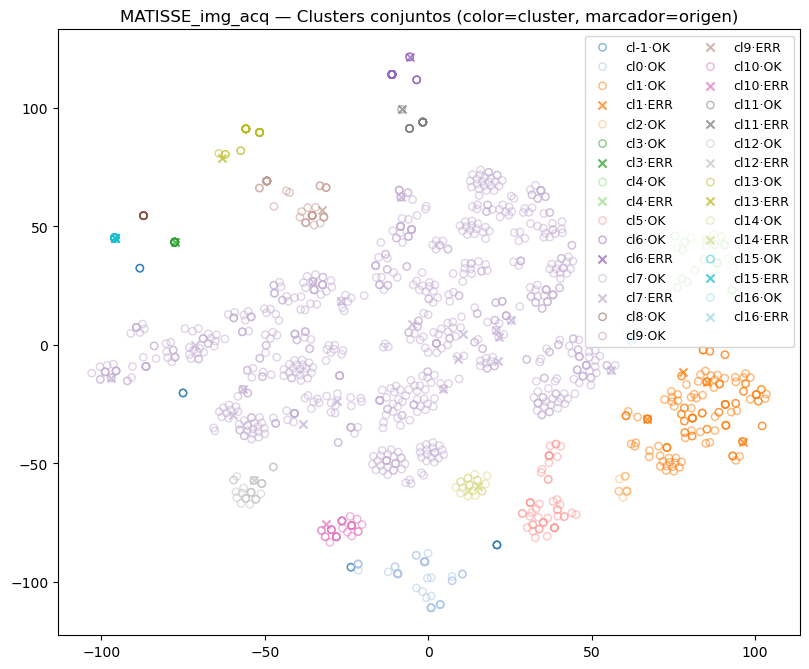


Clustering conjunto (sin usar etiqueta) → MATISSE_img_acq_ft
DBSCAN params: {'eps': np.float32(38.60599), 'min_samples': 7, 'n': 170, 'p': 10}
origen   ERR   OK
cluster          
-1        13  107
 0         6    5
 1         0   10
 2         1    7
 3         0   14
 4         1    6


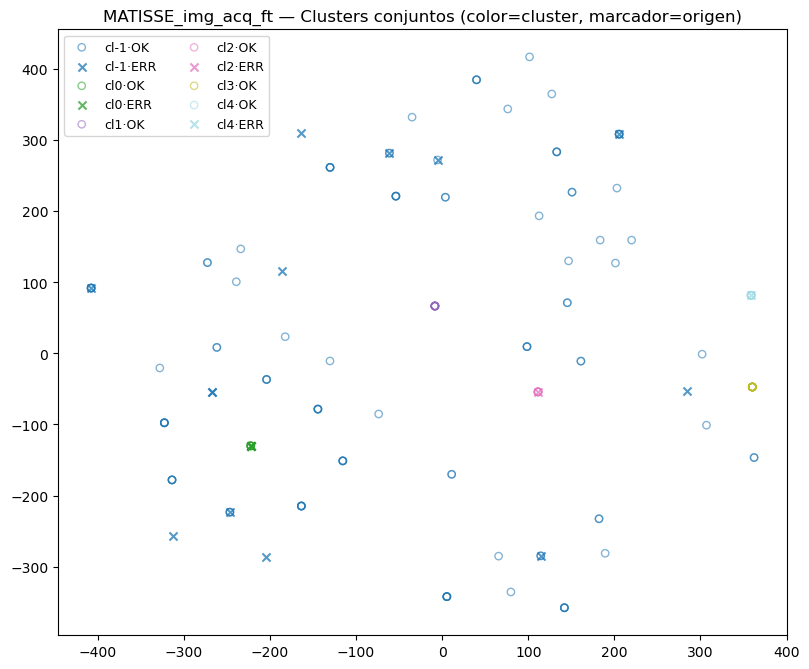

In [ ]:
USE_UMAP = False

for tpl in tpl_params_dict_err.keys():
    df_err = tpl_params_dict_err.get(tpl)
    if df_err is None or df_err.empty:
        print(f"{tpl}: DataFrame vacío. Se omite.")
        continue

    print(f"\nClustering (solo errores) → {tpl}")
    try:
        # Ejecutar clustering (sin comparación con OK)
        df_res, dbp = cluster_todos_en_conjunto(df_err, None, use_umap=USE_UMAP)
    except TypeError:
        # Si la función requiere dos datasets, usa directamente df_err
        df_res, dbp = cluster_todos_en_conjunto(df_err, use_umap=USE_UMAP)

    print("DBSCAN params:", dbp)

    # Resumen por cluster
    print(df_res["cluster"].value_counts())

    # Graficar clusters
    plot_clusters_por_cluster_y_origen(
        df_res,
        titulo=f"{tpl} — Clusters solo errores (color=cluster)"
    )